<a href="https://colab.research.google.com/github/Mitmischer/solar-prediction/blob/main/solar%20prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Package installation

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#!wget -O mini.sh https://repo.anaconda.com/miniconda/Miniconda3-py38_4.8.2-Linux-x86_64.sh
#!chmod +x mini.sh
#!bash ./mini.sh -b -f -p /usr/local
#!conda install -q -y jupyter
#!conda install -q -y google-colab -c conda-forge
#!python -m ipykernel install --name "py38" --user

In [ ]:
#!pip install gpforecaster

In [ ]:
#!pip install git+https://github.com/luisroque/hierarchical_gp_forecaster

In [ ]:
!pip install armagarch

In [ ]:
!pip install gluonts armagarch statsmodels statsforecast s3fs datasetsforecast GPy darts

In [ ]:
!pip install git+https://github.com/Nixtla/neuralforecast.git@main git+https://github.com/RJT1990/pyflux

  Cloning https://github.com/Nixtla/neuralforecast.git (to revision main) to /tmp/pip-req-build-fkxtlfxv
  Running command git clone --filter=blob:none --quiet https://github.com/Nixtla/neuralforecast.git /tmp/pip-req-build-fkxtlfxv
  Resolved https://github.com/Nixtla/neuralforecast.git to commit cd9d2b5028e1e72c2a765e027af2dc6aae5b66f4
  Running command git submodule update --init --recursive -q
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/RJT1990/pyflux to /tmp/pip-req-build-hljn823z
  Running command git clone --filter=blob:none --quiet https://github.com/RJT1990/pyflux /tmp/pip-req-build-hljn823z
  Resolved https://github.com/RJT1990/pyflux to commit 297f2afc2095acd97c12e827dd500e8ea5da0c0f
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.8/64.8 MB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.2/100.2 

In [ ]:
!pip install darts

# Notebook parameters

In [ ]:
# if False, cells that take a lot of time are not run.
slow = False

# "my" preprocessing (maybe too chatty, but it can largely stay as is)

In [ ]:
import pandas as pd
import numpy as np
import armagarch as ag

import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import tensorflow as tf
from datetime import datetime, timezone

# spectral analysis
from scipy import signal
from scipy.signal import periodogram as periodogram_f
from scipy.fft import fftfreq, fftshift
from scipy.fft import fft, ifft, fft2, ifft2

In [ ]:
# with pandas 2.0, one could use date_format='%Y-%m-%d %H:%M:%S%z', but that's not yet available on Arch Linux
solar_ts=pd.read_csv("/content/drive/MyDrive/energy_charts.csv", sep=",", header=0)#date_format='%Y-%m-%d %H:%M:%S%z')#parse_dates={"date": ["Datum"]})

<Axes: xlabel='Datum'>

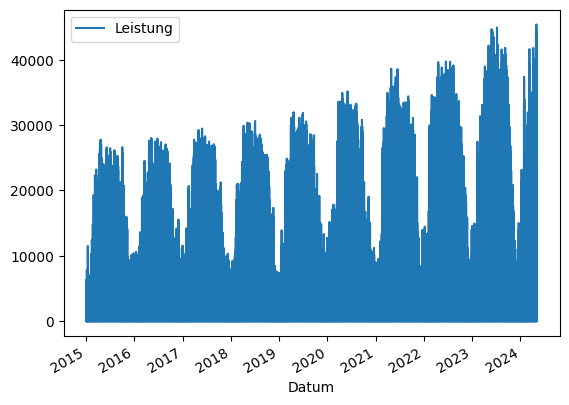

In [ ]:
solar_ts['Datum']=pd.to_datetime(solar_ts['Datum'], format='%Y-%m-%dT%H:%M%z', utc=True)
solar_ts=solar_ts.set_index(keys="Datum",drop=True)
solar_ts.plot()

In [ ]:
adfresult = adfuller(solar_ts[2:30000])
print(adfresult[0])
print(adfresult[1])

-22.445950944044935
0.0


<Axes: xlabel='Datum'>

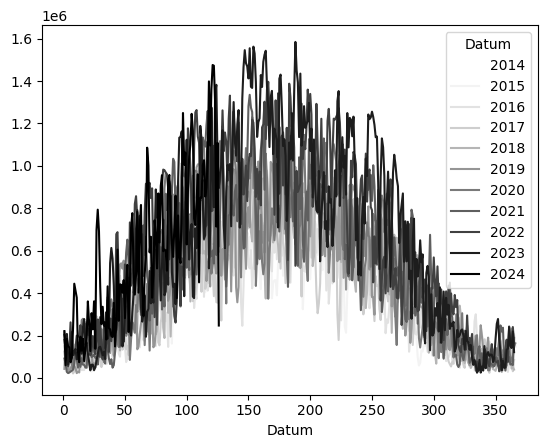

In [ ]:
# see https://stackoverflow.com/questions/30379789/plot-pandas-data-frame-with-year-over-year-data
pv = pd.pivot_table(solar_ts, index=solar_ts.index.dayofyear, columns=solar_ts.index.year,
                    values='Leistung', aggfunc='sum')
pv.plot(cmap="Greys")

<Axes: xlabel='Datum'>

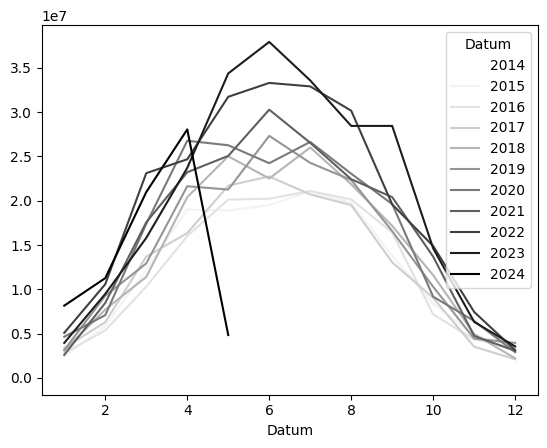

In [ ]:
# see https://stackoverflow.com/questions/30379789/plot-pandas-data-frame-with-year-over-year-data
pv = pd.pivot_table(solar_ts, index=solar_ts.index.month, columns=solar_ts.index.year,
                    values='Leistung', aggfunc='sum')
pv.plot(cmap="Greys")

In [ ]:
# An example of a gap in the data
# TODO: Also, there is duplicate data here that pandas duplicated-function will not find...?
print(solar_ts.index[5660:5680])
print(pd.Series(solar_ts.index[5660:5680]).diff())

DatetimeIndex(['2015-02-28 22:00:00+00:00', '2015-02-28 22:15:00+00:00',
               '2015-02-28 22:30:00+00:00', '2015-02-28 22:45:00+00:00',
               '2015-03-01 00:00:00+00:00', '2015-03-01 00:15:00+00:00',
               '2015-03-01 00:30:00+00:00', '2015-03-01 00:45:00+00:00',
               '2015-03-01 00:00:00+00:00', '2015-03-01 00:15:00+00:00',
               '2015-03-01 00:30:00+00:00', '2015-03-01 00:45:00+00:00',
               '2015-03-01 01:00:00+00:00', '2015-03-01 01:15:00+00:00',
               '2015-03-01 01:30:00+00:00', '2015-03-01 01:45:00+00:00',
               '2015-03-01 02:00:00+00:00', '2015-03-01 02:15:00+00:00',
               '2015-03-01 02:30:00+00:00', '2015-03-01 02:45:00+00:00'],
              dtype='datetime64[ns, UTC]', name='Datum', freq=None)
0                  NaT
1      0 days 00:15:00
2      0 days 00:15:00
3      0 days 00:15:00
4      0 days 01:15:00
5      0 days 00:15:00
6      0 days 00:15:00
7      0 days 00:15:00
8    -1 days +23:

In [ ]:
pd.Series(solar_ts.index.duplicated()).value_counts()

False    327522
True         72
Name: count, dtype: int64

In [ ]:
# Those values need imputation!
pd.date_range(solar_ts.index.min(), solar_ts.index.max(), freq='15Min').difference(solar_ts.index)

DatetimeIndex(['2015-02-28 23:00:00+00:00', '2015-02-28 23:15:00+00:00',
               '2015-02-28 23:30:00+00:00', '2015-02-28 23:45:00+00:00',
               '2015-09-25 02:00:00+00:00', '2015-09-25 02:15:00+00:00',
               '2015-09-25 02:30:00+00:00', '2015-09-25 02:45:00+00:00',
               '2016-02-27 02:00:00+00:00', '2016-02-27 02:15:00+00:00',
               '2016-02-27 02:30:00+00:00', '2016-02-27 02:45:00+00:00',
               '2016-09-30 02:00:00+00:00', '2016-09-30 02:15:00+00:00',
               '2016-09-30 02:30:00+00:00', '2016-09-30 02:45:00+00:00',
               '2017-02-26 02:00:00+00:00', '2017-02-26 02:15:00+00:00',
               '2017-02-26 02:30:00+00:00', '2017-02-26 02:45:00+00:00',
               '2017-09-29 02:00:00+00:00', '2017-09-29 02:15:00+00:00',
               '2017-09-29 02:30:00+00:00', '2017-09-29 02:45:00+00:00',
               '2018-02-25 02:00:00+00:00', '2018-02-25 02:15:00+00:00',
               '2018-02-25 02:30:00+00:00', '2018-0

In [ ]:
# This add NaN as value for the missing indices, we can impute this later.
solar_ts = solar_ts.resample("15Min").first()
# As only a few values need imputation, so the choice of the imputation algorithm does not matter much.
solar_ts = solar_ts.interpolate(method="time")
# Only now can we infer a frequency.
solar_ts=solar_ts.asfreq(pd.infer_freq(solar_ts.index))

In [ ]:
# There are no duplicated dates, good!
# (Although, a bit questionable, see above)
np.count_nonzero(solar_ts.index.duplicated())

0

In [ ]:
solar_ts=solar_ts.asfreq(pd.infer_freq(solar_ts.index))

<Axes: xlabel='Datum'>

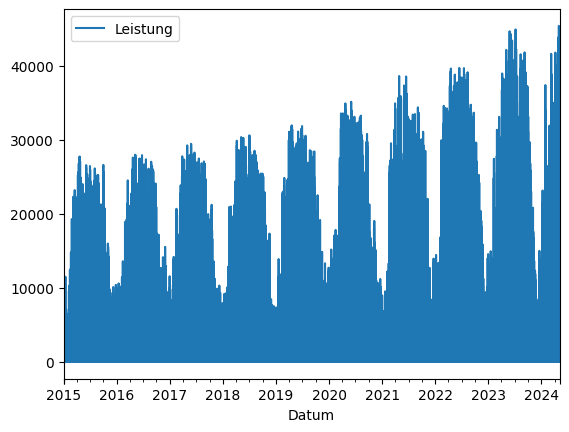

In [ ]:

solar_ts.plot()

In [ ]:
solar_ts_series = solar_ts.Leistung

<Axes: xlabel='Datum'>

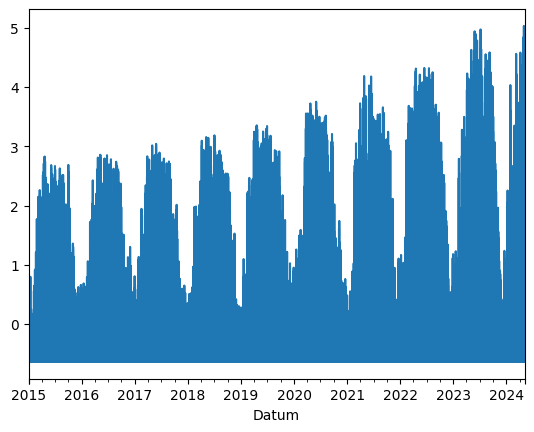

In [ ]:
# Normalize
train_size = int(len(solar_ts_series) * 0.9)
ts_train = solar_ts_series[:train_size]
ts_test = solar_ts_series[train_size:]

# we cannot normalize over the test data as we don't have that yet!
avg, dev = ts_train.mean(), ts_train.std()
solar_ts_series = (solar_ts_series - avg)/dev
solar_ts_series.plot()

<Axes: xlabel='Datum'>

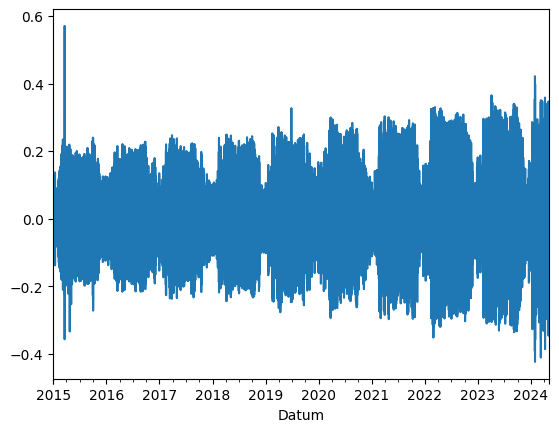

In [ ]:
# Remove trend (TODO: compare with the approach in the Fourier series video, where they also detrend?)
solar_ts_series = solar_ts_series.diff().dropna()
solar_ts_series.plot()

In [ ]:
# Consider taking another difference: solar_ts_series = solar_ts_series.diff().dropna()
# solar_ts_series.plot()

<Axes: xlabel='Datum'>

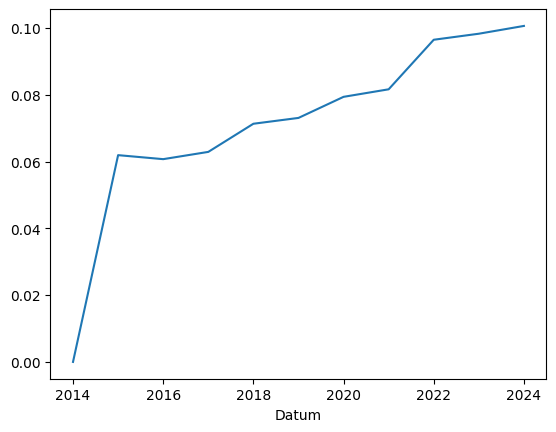

In [ ]:
# remove increasing volatility - or (TODO: use a (G)ARCH here).
annual_volatility = solar_ts_series.groupby(solar_ts_series.index.year).std()
annual_vol_per_day = solar_ts_series.index.map(lambda d: annual_volatility.loc[d.year])
solar_ts_series_corrected_variance = solar_ts_series/annual_vol_per_day
annual_volatility.plot()

Sure, we leak information here. But the volatility is easy enough to model with a linear function, so I'd argue that's fine!

<Axes: xlabel='Datum'>

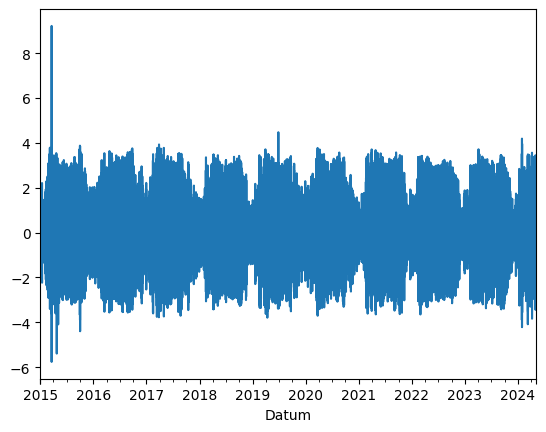

In [ ]:
solar_ts_series_corrected_variance.plot()

In [ ]:
# looks unnecessary to me!
# ritvik takes monthly means here
# why not take dayofyear?
#monthly_mean = solar_ts_series_corrected_variance.groupby(solar_ts_series_corrected_variance.index.month).mean()
#monthly_mean_per_day = solar_ts_series_corrected_variance.index.map(lambda d: monthly_mean.loc[d.month])
#solar_ts_series_corrected_variance= solar_ts_series_corrected_variance - monthly_mean_per_day

In [ ]:
# we only take the first few samples as my RAM explodes otherwise
adfresult = adfuller(solar_ts_series_corrected_variance[3:30000])
print(adfresult[0])
print(adfresult[1])
adfresult = adfuller(solar_ts_series_corrected_variance[120000:150000])
print(adfresult[0])
print(adfresult[1])

-45.674667731901366
0.0
-43.56622851218715
0.0


In [ ]:
solar_ts_series_corrected_variance=solar_ts_series_corrected_variance[~np.isnan(solar_ts_series_corrected_variance)]


# Import Andrea (works)

In [ ]:
import huggingface_hub
import pandas as pd
import numpy as np

In [ ]:
splits = {'train': 'train_ts.csv', 'validation': 'val_ts.csv', 'test': 'test_ts.csv'}
df_train = pd.read_csv("hf://datasets/Creatorin/solarpower/" + splits["train"])
df_validation = pd.read_csv("hf://datasets/Creatorin/solarpower/" + splits["validation"])
df_test = pd.read_csv("hf://datasets/Creatorin/solarpower/" + splits["test"])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
df = pd.concat([df_train, df_validation, df_test])
ts = df["Leistung"]
ts.index = pd.to_datetime(ts.index, utc=True)

In [ ]:
# Interpolation
ts = ts.interpolate(method="time")
# Only now can we infer a frequency.
ts = ts.asfreq(pd.infer_freq(ts.index))

In [ ]:
# Normalize
avg_train, dev_train = ts.mean(), ts.std()
ts_series = (ts - avg_train)/dev_train

<Axes: >

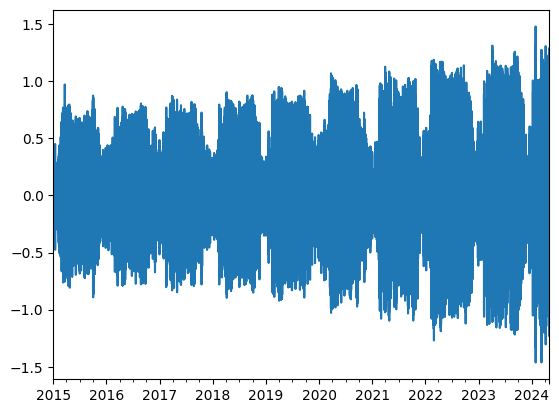

In [ ]:
# Remove trend
ts_series = ts_series.diff().dropna()
ts_series.plot()

In [ ]:
# remove increasing volatility

def remove_volatility(ts):
    annual_volatility = ts.groupby(ts.index.year).std()
    annual_vol_per_day = ts.index.map(lambda d: annual_volatility.loc[d.year])
    ts_corrected_variance = ts/annual_vol_per_day
    monthly_mean = ts_corrected_variance.groupby(ts_corrected_variance.index.month).mean()
    monthly_mean_per_day = ts_corrected_variance.index.map(lambda d: monthly_mean.loc[d.month])
    ts_corrected_variance= ts_corrected_variance - monthly_mean_per_day
    ts_corrected_variance= ts_corrected_variance[~np.isnan(ts_corrected_variance)]
    return ts_corrected_variance

In [ ]:
ts = remove_volatility(ts_series)

# some spectral analysis (works, also with the new data, just too chatty)

(0.0, 2000.0)

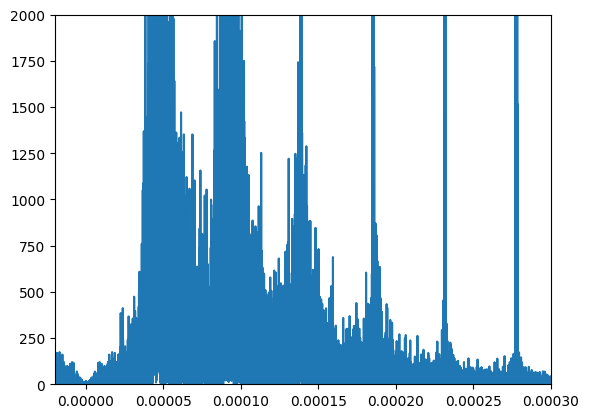

In [ ]:
# ts has period 15 minutes
dt = 15*60
rate = 1/dt
periodogram = np.abs(fft(np.asarray(ts)))**2*dt/(len(ts))
frequencies = fftfreq(len(ts), d=1/rate)
frequencies
plt.plot(fftshift(frequencies), fftshift(periodogram))
plt.xlim(-0.00002, 3*0.0001)
plt.ylim(0, 10000/5)

(0.0, 10000.0)

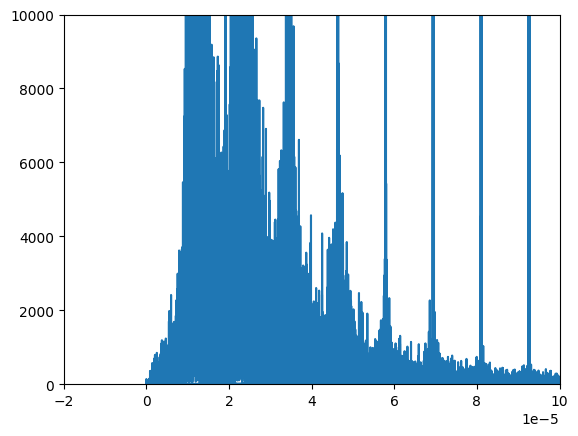

In [ ]:
# looks (and should be!) similar to the "manual" calculation above.
# Note that in the manual calculation, we get a symmetric graph. That's to be expected (check out the videos).
frequencies, periodogram = periodogram_f(np.asarray(solar_ts_series_corrected_variance), fs=rate, window="hamming")
plt.plot(fftshift(frequencies), fftshift(periodogram))
plt.xlim(-0.00002, 0.0001)
plt.ylim(0, 10000)

/usr/local/lib/python3.10/dist-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


(0.0, 6.666666666666667)

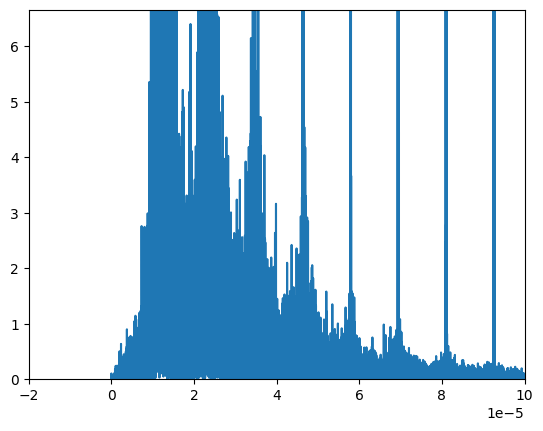

In [ ]:
# yet another way to calculate the FFT, from the "denoising" video.
# However, apparently, the signal is now dampened. The frequencies themselves are correct, though
# Note how damped the signal appears visually already although the y-scale is really small!
n = len(solar_ts_series_corrected_variance)
fhat = np.fft.fft(solar_ts_series_corrected_variance, n)
PSD = fhat*np.conj(fhat)/n
freq = (1/(dt*n))*np.arange(n)
L= np.arange(1, np.floor(n/2), dtype="int")
plt.plot(freq[L], PSD[L])
plt.xlim(-0.00002, 0.0001)
# why the difference in magnitude?
plt.ylim(0, 10000/1500)

(0.0, 50000.0)

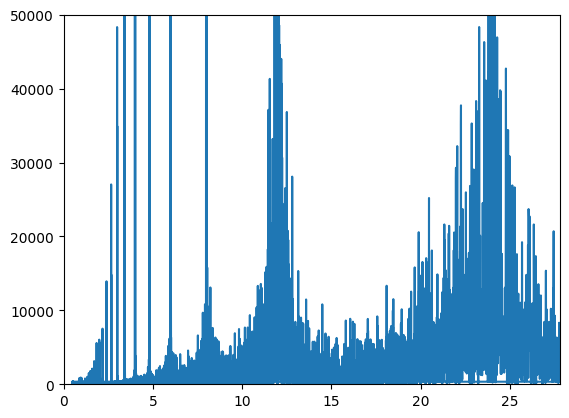

In [ ]:
periodogram_as_series = pd.Series(fftshift(periodogram), index=fftshift(frequencies))
periodogram_as_series = periodogram_as_series[periodogram_as_series.index > 0]
# convert index from frequencies to periods and convert the periods to hours
# TODO: is the calculation to hours correct (note that  we already specified the sampling rate during the fft!)?
periodogram_as_series.index = (1/periodogram_as_series.index)/3600
plt.plot(periodogram_as_series)
plt.xlim(0,100000/3600)
plt.ylim(0, 5000*10)

[]

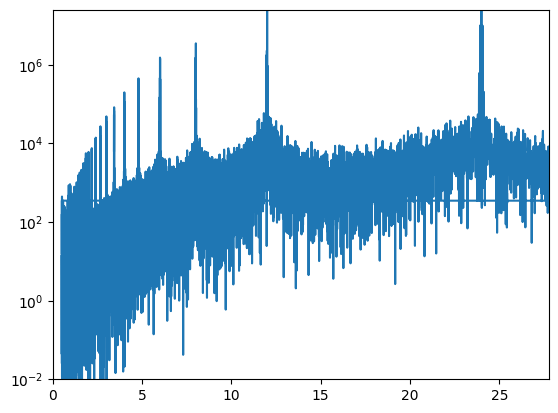

In [ ]:
periodogram_as_series = pd.Series(fftshift(periodogram), index=fftshift(frequencies))
periodogram_as_series = periodogram_as_series[periodogram_as_series.index > 0]
# convert index from frequencies to periods and convert the periods to hours
# TODO: is the calculation to hours correct (note that  we already specified the sampling rate during the fft!)?
periodogram_as_series.index = (1/periodogram_as_series.index)/3600
plt.plot(periodogram_as_series)
plt.xlim(0,100000/3600)
plt.ylim(0, 5000*50)
plt.ylim(1e-2, 100*5000*50)
plt.semilogy()

[]

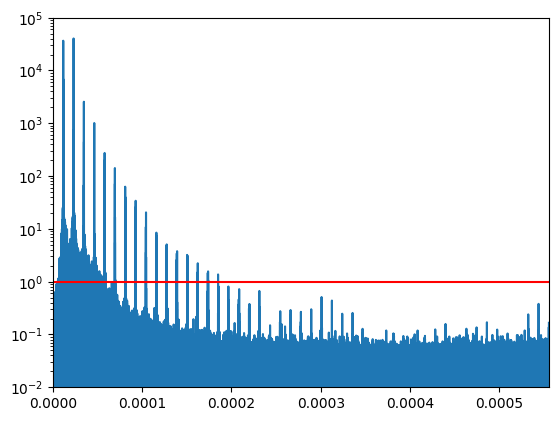

In [ ]:
# Now decide on the frequencies to cut off.
plt.plot(freq, PSD)
plt.ylim(1e-2,1e5)
plt.xlim(0,max(freq)/2)
plt.axhline(y=1e0, color="r")
plt.semilogy()

In [ ]:
# We'll only retain frequencies with powers above the red line in the graph above.
# I chose it such that almost all high-power frequencies are retained. We get some noisy frequencies in (at the tails) but the majority is filtered.
indices = PSD > 1e-1# 0.5 #1e0
# Filter and reconstruct the signal on the retained frequencies (reverse fourier transform)
PSDclean = PSD*indices
fhat = indices*fhat
ffilt = np.fft.ifft(fhat)

In [ ]:
# number of surviving frequencies
np.sum(indices)

34767

[]

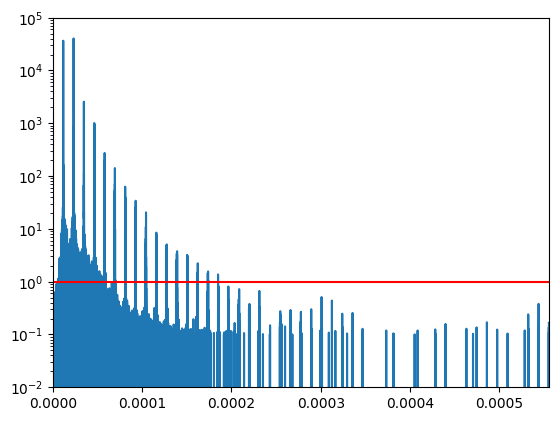

In [ ]:
# small sanity check: our new spectrum looks like this: nice, huh?
plt.plot(freq, PSDclean)
plt.ylim(1e-2,1e5)
plt.xlim(0,max(freq)/2)
plt.axhline(y=1e0, color="r")
plt.semilogy()

/usr/local/lib/python3.10/dist-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


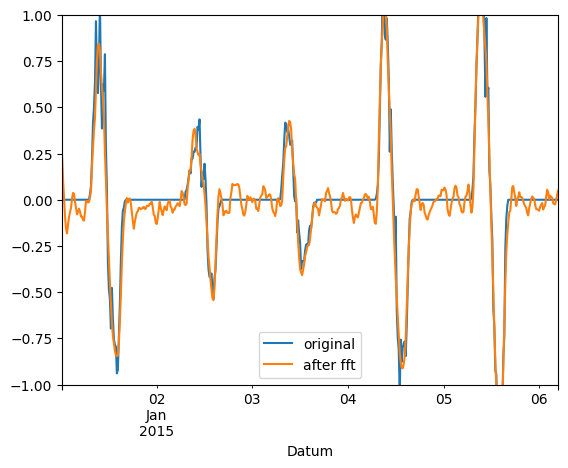

In [ ]:
solar_ts_series_corrected_variance[1:500].plot()
plt.ylim(-4,4)
pd.Series(ffilt[1:500], solar_ts_series_corrected_variance.index[1:500]).plot()
plt.ylim(-1,1)
plt.legend(["original", "after fft"])

Maybe peak detection would have been better here ...? Further work :)
Generally, in much of the settings we investigated, FFT had problems with the zero production at night.
You can play around with the parameter in
indices = PSD > X
to obtain the comparisons in the presentation.

In [ ]:
# TODO: use SARIMA, => detrend and remove saisonality
# Take a look the the residuals
# is the model good?
# Then, the residuals have no (p)ACF
# check QQ - WN has no heavy tails :)
# also consider: https://www.youtube.com/watch?v=4zV-ZyQHl7s

# TODO: decompose + fit SARIMA model
# before: continue with denoising :)



# FT model (works also with the 1h data)

In [ ]:
# Evtl. erwägen eins der GP-Repos zu porten? z.B. ABCDflow?

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from darts import TimeSeries
from darts.models import FFT, AutoARIMA, ExponentialSmoothing, Theta
from darts.metrics import mae
from darts.utils.missing_values import fill_missing_values

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [ ]:
train_size = np.sum(ts.index < pd.Timestamp('2020-01-01 00:00:00+0000', tz='UTC'))

In [ ]:
from darts import TimeSeries

#train_size = int(len(solar_ts_series_corrected_variance) * 0.3)
train_size = np.sum(ts.index < pd.Timestamp('2020-01-01 00:00:00+0000', tz='UTC'))
ts_train = ts[:train_size]
ts_test = ts[train_size:]

darts_ts_train = TimeSeries.from_series(ts_train)
darts_ts_test = TimeSeries.from_series(ts_test)

In [ ]:
plt.figure(figsize=(19,4))

<Figure size 1900x400 with 0 Axes>

<Figure size 1900x400 with 0 Axes>

In [ ]:
def do_fourier(model, darts_ts_train, darts_ts_test):
  model.fit(darts_ts_train)
  pred_val = model.predict(len(darts_ts_test))
  plt.figure(figsize=(24,4))
  #darts_ts_train.plot(label="train")
  darts_ts_test.plot(label="val")
  print("MAE:", mae(pred_val, darts_ts_test))
  return pred_val.plot(label="prediction")

MAE: 0.2512336331963573


<Axes: xlabel='time'>

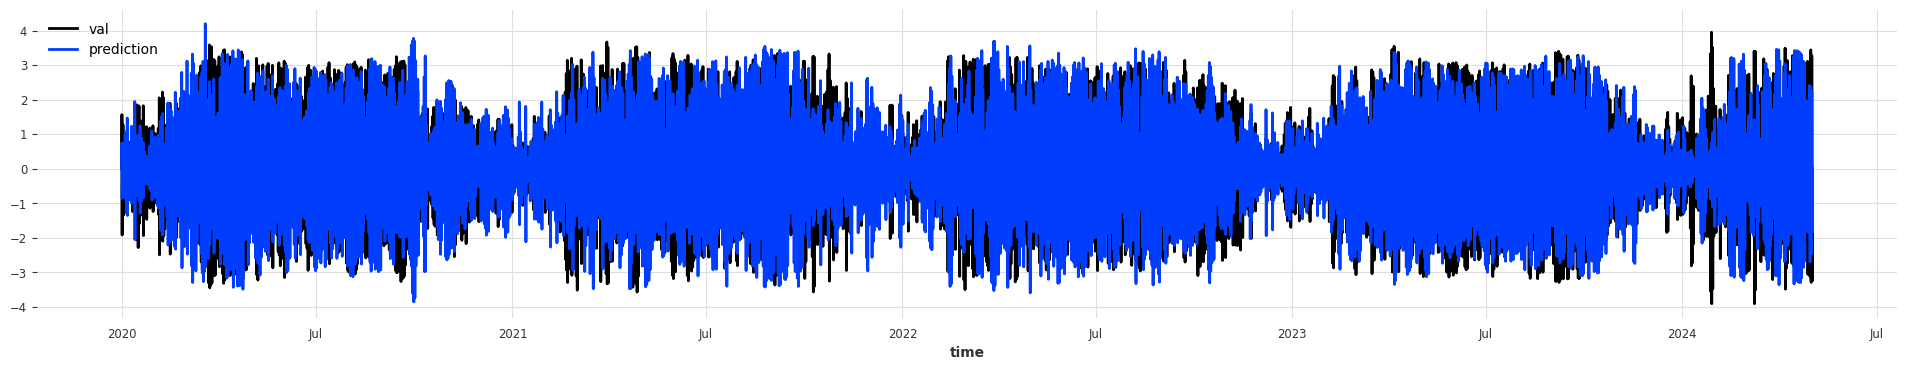

In [ ]:
# baseline FFT model
model = FFT(required_matches=set(), nr_freqs_to_keep=None)
do_fourier(model, darts_ts_train, darts_ts_test)

MAE: 0.6026495418647154


<Axes: xlabel='time'>

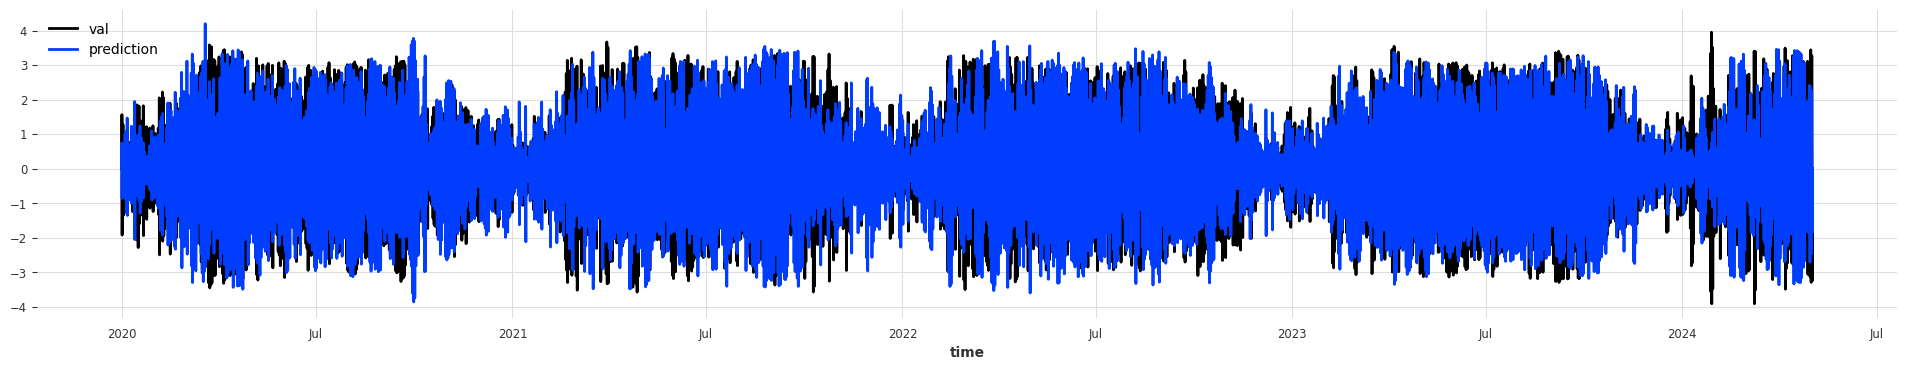

In [ ]:
# interesting: matching day and month makes the result worse whereas it should
# make it better!
model = FFT(required_matches={"day", "month"}, nr_freqs_to_keep=None)
do_fourier(model, darts_ts_train, darts_ts_test)

MAE: 0.20417528060524262


<Axes: xlabel='time'>

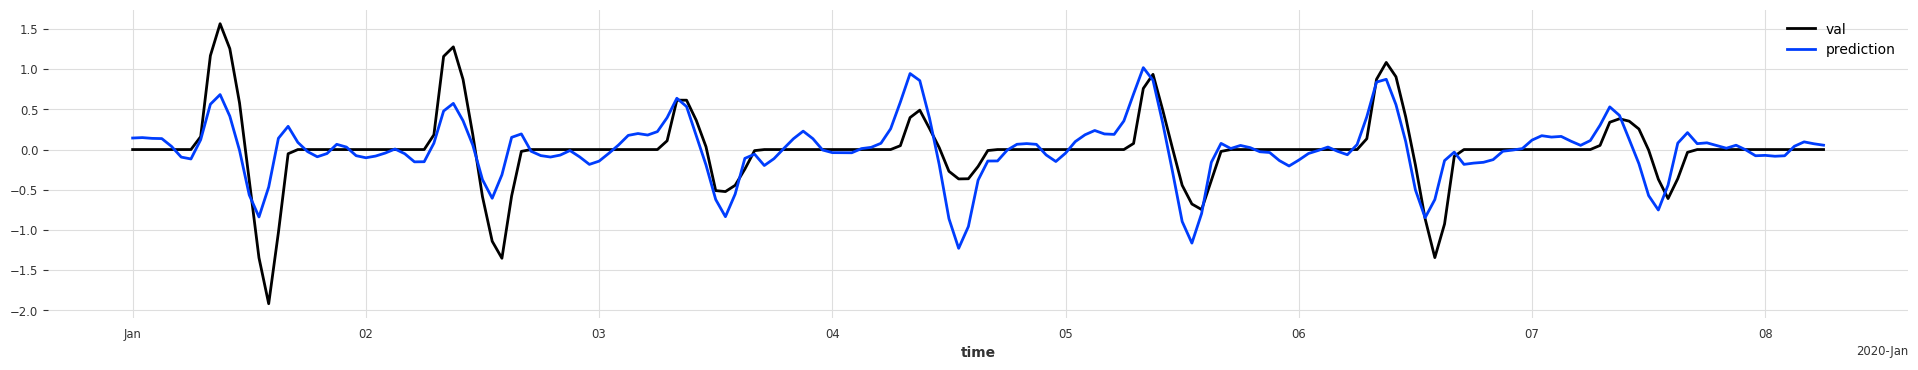

In [ ]:
# zoom-in
# the plot in the presentation was done on the data on their original resolution
model = FFT(nr_freqs_to_keep=5000)
do_fourier(model, darts_ts_train, darts_ts_test[:175])

In [ ]:
import darts.metrics.metrics

if slow:
  model = FFT()
  model.gridsearch(
  parameters={
        "nr_freqs_to_keep": [10, 50, 100, 500, 1000, 2000, 5000, 10000, 15000, 20000]
    },
    series=darts_ts_train,
    val_series=darts_ts_test,
    verbose=True,
    metric = darts.metrics.metrics.mae
  )

NameError: name 'slow' is not defined

#GP (as filtering method, ready)

We employ Gaussian processes as a filtering / preprocessing method, not for forecasting.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.gaussian_process.kernels import ExpSineSquared, RBF

from darts import TimeSeries
from darts.models import GaussianProcessFilter
from darts.utils import timeseries_generation as tg

In [ ]:
NOISE_DISTANCE = 0.4
SAMPLE_SIZE = 200
np.random.seed(42)

/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


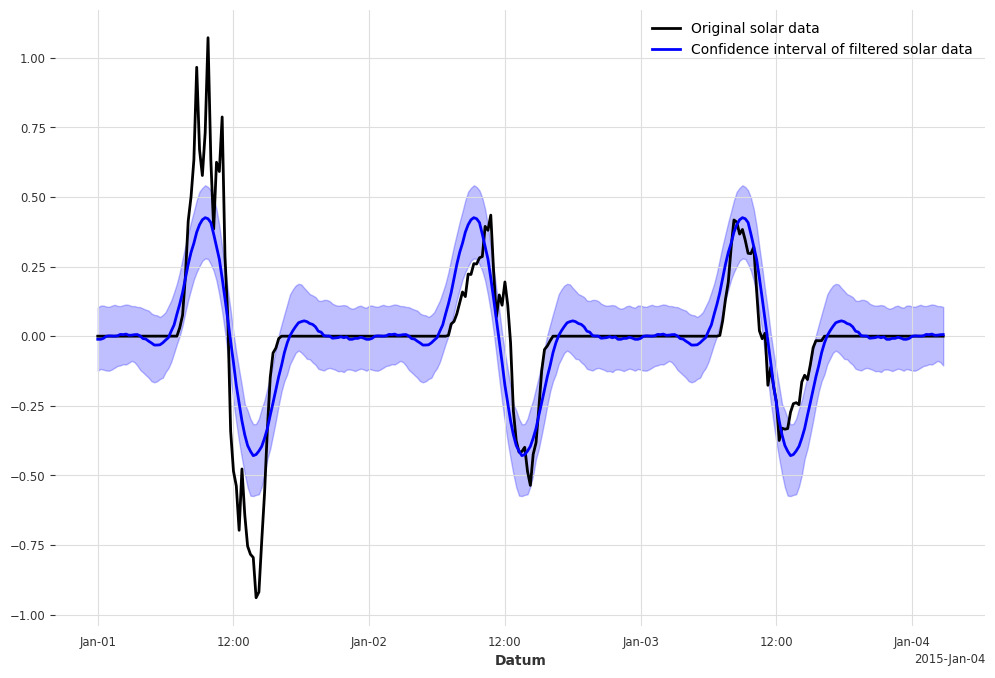

In [ ]:
kernel = ExpSineSquared()

gpf = GaussianProcessFilter(
    kernel=kernel, alpha=NOISE_DISTANCE / 2, n_restarts_optimizer=100
)


filtered_x_samples = gpf.filter(darts_ts_train[:300], num_samples=150)

plt.figure(figsize=[12, 8])
darts_ts_train[:300].plot(color="black", label="Original solar data")
filtered_x_samples.plot(color="blue", label="Confidence interval of filtered solar data")
plt.legend()

Given the general energy curve shape (sinusoidal) and the increasing trend in data volatility, ExpSineSquared is the obvious first choice, but its performance is not great.
The results look similar to FFT, but there is big problem - the resulting output is just repetitive (each 1-day period is identical).
We've seen this for the FFT, too, if too few frequencies were retained. Even for the very small training set, the cell takes a lot of time to execute, so the effect of raising num_samples could not be investigated further. Also, the runtimes are unbearingly slow.


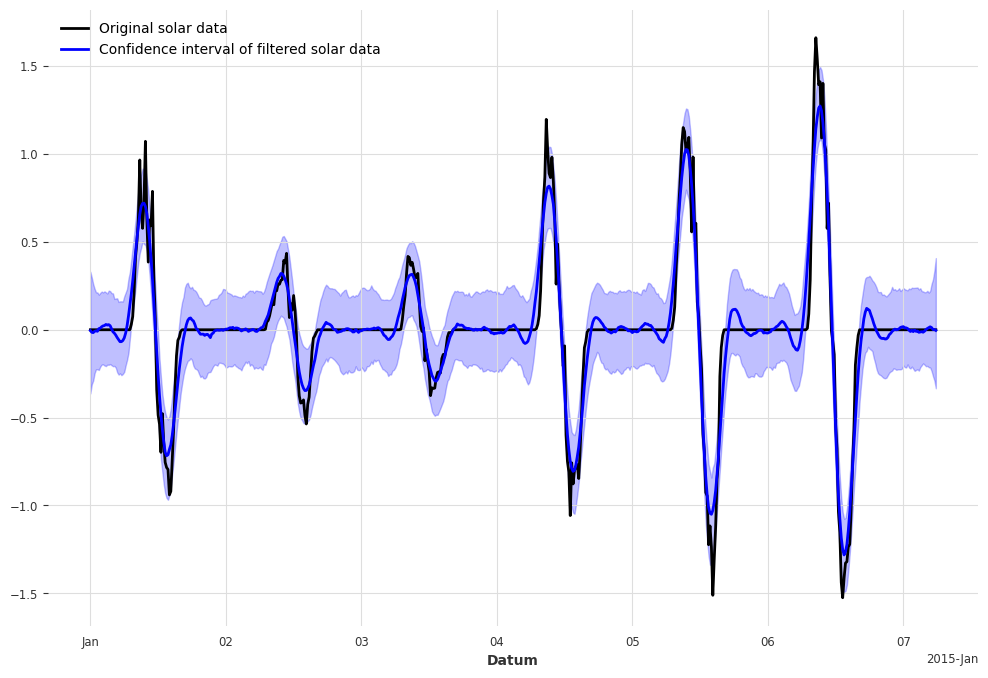

In [ ]:
kernel = RBF()

filtered_x_samples = gpf.filter(darts_ts_train[:600], num_samples=200) # num_samples were 100

plt.figure(figsize=[12, 8])
darts_ts_train[:600].plot(color="black", label="Original solar data")
filtered_x_samples.plot(color="blue", label="Confidence interval of filtered solar data")
plt.legend()

The RBF kernel performs much better here, capturing the general peak height. Still, as with FFT, there are problems at night time.
One can safely reduce num_samples to 50 without high increases in error, still the high execution times make applying the filter on the whole dataset unfeasible.

Fazit:
Rein/Rauszoomen bei den Plots liefert unterschiedliche Intuitionen
==> Entsprechend Frequenzen mit Vorsicht zu genießen

# AD1/AD2 (works also on the 1h data)

In [ ]:
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt

In [ ]:
TIME_STEPS = 288

# Generated training sequences for use in the model:
# rolling windows of size TIME_STEPS
def create_sequences(values, time_steps):
    output = []
    for i in range(len(values) - time_steps + 1):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)


def prepare_data(x, sample_type, time_steps):
    # normalize x (=train or test data) and create windows.
    x_mean = x.mean()
    x_std = x.std()
    df_training_value = (x - x_mean) / x_std
    print(f"Number of {sample_type} samples:", len(x))

    x_ret = create_sequences(df_training_value.values, time_steps)
    print("{sample_type} input shape: ", x_ret.shape)
    return x_ret

def AE_anomaly_detection(x_train, x_test, time_steps):
    # change this to False to use an LSTM instead.
    simple = True

    x_train = prepare_data(x_train, "training", time_steps)

    if simple:
      model = keras.Sequential(
          [
            layers.Input(shape=(x_train.shape[1], x_train.shape[2])),
            layers.Conv1D(
                filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
            ),
            layers.Dropout(rate=0.2),
            layers.Conv1D(
                filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
            ),
            layers.Conv1DTranspose(
                filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
            ),
            layers.Dropout(rate=0.2),
            layers.Conv1DTranspose(
                filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
            ),
            layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
          ]
      )
    else:
      model = keras.Sequential(
          [
            layers.LSTM(128, input_shape=(x_train.shape[1], x_train.shape[2])),
            layers.Dropout(rate=0.2),
            layers.RepeatVector(x_train.shape[1]),
            layers.LSTM(128, return_sequences=True),
            layers.Dropout(rate=0.2),
            layers.TimeDistributed(layers.Dense(x_train.shape[2])),
          ]
      )


    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
    history = model.fit(
    x_train,
    x_train,
    epochs=50,
    batch_size=128,
    validation_split=0.1,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
       ],
    )

    ## Get train MAE loss, compute reconstruction error threshold.
    x_train_pred = model.predict(x_train)
    train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

    plt.hist(train_mae_loss, bins=50)
    plt.xlabel("Train MAE loss")
    plt.ylabel("No of samples")
    plt.show()

    # Get reconstruction loss threshold.
    # Here, we use 90% of the maximum training threshold, but one could
    # experiment with this value!
    threshold = np.max(train_mae_loss)*0.9
    print("Reconstruction error threshold: ", threshold)


    x_test = prepare_data(x_test, "test", time_steps)

    ## Get test MAE loss, determine anomalous slices.
    x_test_pred = model.predict(x_test)
    test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)
    test_mae_loss = test_mae_loss.reshape((-1))

    plt.hist(test_mae_loss, bins=50)
    plt.xlabel("test MAE loss")
    plt.ylabel("No of samples")
    plt.show()

    # Detect all the anomalous slices.
    anomalies = test_mae_loss > threshold
    print(anomalies)
    print("Number of anomaly samples: ", np.sum(anomalies))
    return anomalies

Number of training samples: 299
Training input shape:  (12, 288, 1)
Epoch 1/50
1/1 [==============================] - 6s 6s/step - loss: 0.8512 - val_loss: 1.1269
Epoch 2/50
1/1 [==============================] - 1s 909ms/step - loss: 0.8547 - val_loss: 1.0533
Epoch 3/50
1/1 [==============================] - 1s 740ms/step - loss: 0.8536 - val_loss: 1.0021
Epoch 4/50
1/1 [==============================] - 1s 1s/step - loss: 0.8462 - val_loss: 1.0328
Epoch 5/50
1/1 [==============================] - 1s 1s/step - loss: 0.8490 - val_loss: 1.0524
Epoch 6/50
1/1 [==============================] - 1s 1s/step - loss: 0.8509 - val_loss: 1.0385
Epoch 7/50
1/1 [==============================] - 1s 1s/step - loss: 0.8498 - val_loss: 1.0136
Epoch 8/50
1/1 [==============================] - 1s 1s/step - loss: 0.8483 - val_loss: 1.0016
Epoch 9/50
1/1 [==============================] - 1s 1s/step - loss: 0.8465 - val_loss: 1.0058
Epoch 10/50
1/1 [==============================] - 1s 879ms/step - loss

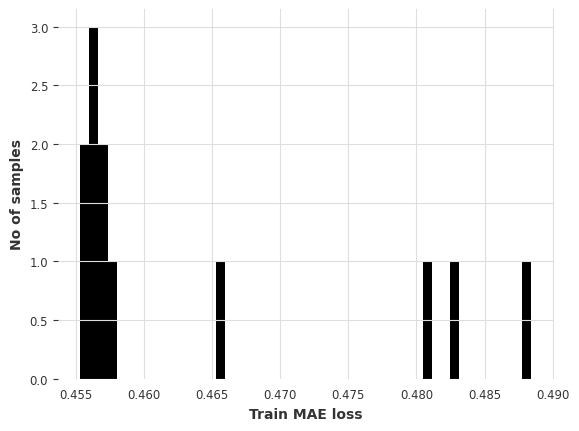

Reconstruction error threshold:  0.439587666734802
Test input shape:  (112, 288, 1)
4/4 [==============================] - 2s 353ms/step


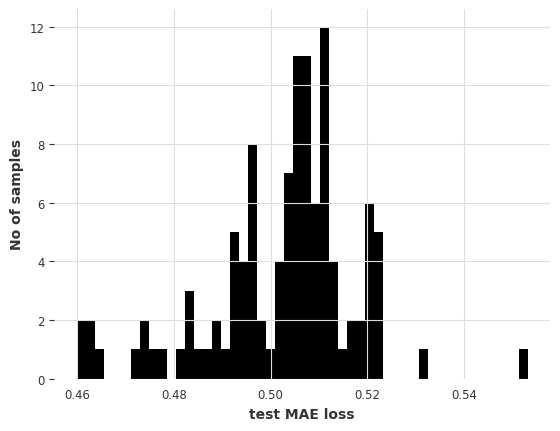

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True]
Number of anomaly samples:  112


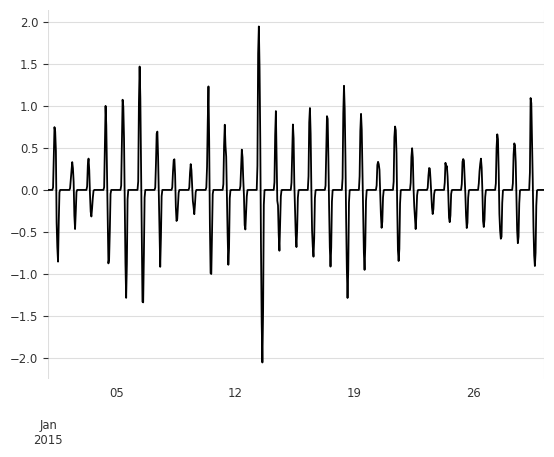

In [ ]:
TIME_STEPS = 288
train_end_idx=300

test_part = ts[(train_end_idx+1):]

anomalies = AE_anomaly_detection(ts.iloc[1:train_end_idx].to_frame(),
                                 ts.iloc[(train_end_idx+1):].to_frame(),
                                 time_steps=TIME_STEPS)

anomalous_data_indices = []
for data_idx in range(TIME_STEPS - 1, len(test_part) - TIME_STEPS + 1):
    # get all windows where the sample is in
    sample_anomalies = anomalies[data_idx - TIME_STEPS + 1 : data_idx]
    # a sample is anomalous if it is in more than 90% anomalous windows
    if np.mean(sample_anomalies) > 0.9:
        anomalous_data_indices.append(data_idx)
abnormal_subset = test_part.iloc[anomalous_data_indices]

fig, ax = plt.subplots()
ts.plot(legend=False, ax=ax)
if len(abnormal_subset)>0:
  abnormal_subset.plot(legend=False, ax=ax, color="r")
plt.show()

Play around with the parameter simple to select either the CNN or the LSTM and the parameter train_end_idx.
Only samples in the test set are evaluated for being anomalous, but we could apply the test on the training data, too.
Note that for the plots in the presentation, the time series with increasing volatility was used.

# NBEATS (Darts), (works on the 1h data), *should* be good to go, needs testing on the GPU.

In [ ]:
from darts import TimeSeries, concatenate
from darts.utils.callbacks import TFMProgressBar
from darts.models import NBEATSModel
from darts.dataprocessing.transformers import Scaler, MissingValuesFiller
from darts.metrics import mape, r2_score
from darts.datasets import EnergyDataset
from darts import concatenate

In [ ]:
def display_forecast(pred_series, ts_transformed, forecast_type, start_date=None):
    plt.figure(figsize=(8, 5))
    if start_date:
        ts_transformed = ts_transformed.drop_before(start_date)
    ts_transformed.univariate_component(0).plot(label="actual")
    pred_series.plot(label=("historic " + forecast_type + " forecasts"))
    plt.title(
        "R2: {}".format(r2_score(ts_transformed.univariate_component(0), pred_series))
    )
    plt.legend()

def generate_torch_kwargs():
    # run torch models on CPU, and disable progress bars for all model stages except training.
    return {
        "pl_trainer_kwargs": {
            "accelerator": "cpu",
            "callbacks": [TFMProgressBar(enable_train_bar_only=True)],
        }
    }

<Axes: xlabel='time'>

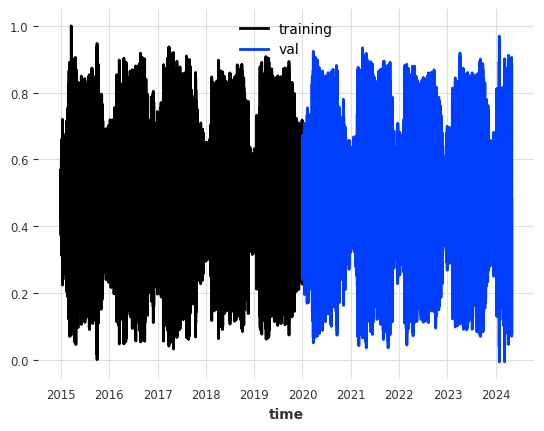

In [ ]:
scaler = Scaler()

#ts_train_orig = solar_ts_series[:train_size]
#ts_test_orig = solar_ts_series[train_size:]

#darts_ts_train_orig = TimeSeries.from_series(ts_train_orig)
#darts_ts_test_orig = TimeSeries.from_series(ts_test_orig)

#darts_ts_train_orig_scaled = scaler.fit_transform(darts_ts_train_orig)
#darts_ts_test_orig_scaled = scaler.transform(darts_ts_test_orig)
#darts_ts_full_orig_scaled = scaler.transform(TimeSeries.from_series(solar_ts_series))

#darts_ts_train_orig_scaled.plot(label="training")
#darts_ts_test_orig_scaled.plot(label="val")

train_size = np.sum(ts.index < pd.Timestamp('2020-01-01 00:00:00+0000', tz='UTC'))
ts_train = ts[:train_size]
ts_test = ts[train_size:]

# data is not normal yet!
darts_ts_train = scaler.fit_transform(TimeSeries.from_series(ts_train))
darts_ts_test = scaler.transform(TimeSeries.from_series(ts_test))
darts_ts_full = scaler.transform(TimeSeries.from_series(ts))

darts_ts_train.plot(label="training")
darts_ts_test.plot(label="val")

In [ ]:
model_name = "nbeats_run"
model_nbeats = NBEATSModel(
    input_chunk_length=30,
    output_chunk_length=7,
    generic_architecture=True,
    num_stacks=10,
    num_blocks=1,
    num_layers=4,
    layer_widths=512,
    n_epochs=100,
    nr_epochs_val_period=1,
    batch_size=800,
    random_state=42,
    model_name=model_name,
    save_checkpoints=True,
    force_reset=True,
    **generate_torch_kwargs(),
)

In [ ]:
model_nbeats.fit(darts_ts_train, val_series=darts_ts_test)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 8.1 M  | train
-------------------------------------------------------------
8.1 M     Trainable params
2.7 K     Non-trainable params
8.1 M     Total params
32.368    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


NBEATSModel(output_chunk_shift=0, generic_architecture=True, num_stacks=10, num_blocks=1, num_layers=4, layer_widths=512, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.0, activation=ReLU, input_chunk_length=30, output_chunk_length=7, n_epochs=100, nr_epochs_val_period=1, batch_size=800, random_state=42, model_name=nbeats_run, save_checkpoints=True, force_reset=True, pl_trainer_kwargs={'accelerator': 'cpu', 'callbacks': [<darts.utils.callbacks.TFMProgressBar object at 0x7cfd837551e0>]})

In [ ]:
model_nbeats = NBEATSModel.load_from_checkpoint(model_name=model_name, best=True)

ERROR:darts.models.forecasting.torch_forecasting_model:FileNotFoundError: There is no file matching prefix best-* in /content/darts_logs/nbeats_run/checkpoints


FileNotFoundError: There is no file matching prefix best-* in /content/darts_logs/nbeats_run/checkpoints

In [ ]:
pred_series = model_nbeats.historical_forecasts(
    darts_ts_full,
    start=darts_ts_test.start_time(),
    forecast_horizon=7,
    stride=7,
    last_points_only=False,
    retrain=False,
    verbose=True,
)
pred_series = concatenate(pred_series)

display_forecast(
    pred_series,
    darts_ts_full,
    "7 day",
    start_date=darts_ts_test.start_time(),
)

In [ ]:
nbeats_pred = model_nbeats.predict(n=24*4*7)
nbeats_test = darts_ts_test[0:(24*4*7)]

In [ ]:
nbeats_pred.plot()
nbeats_test.plot()

# NHITS

In [ ]:
from statsforecast import StatsForecast
from ray import tune

from neuralforecast.auto import AutoNHITS, AutoLSTM
from neuralforecast.core import NeuralForecast

from neuralforecast.losses.pytorch import DistributionLoss, MQLoss

import logging
logging.getLogger("pytorch_lightning").setLevel(logging.WARNING)

In [ ]:
solar_ts_series_nhits = solar_ts_series.reset_index().rename(columns={"Datum":"ds","Leistung":"y"})
ts_nhits = ts.reset_index().rename(columns={"index":"ds", 0:"y"})
# NeuralForecast is inherently multivariate. We just assign UID as our unique
# id, the exact choice doesn't matter.
ts_nhits.insert(column="unique_id", value="UID", loc=0)

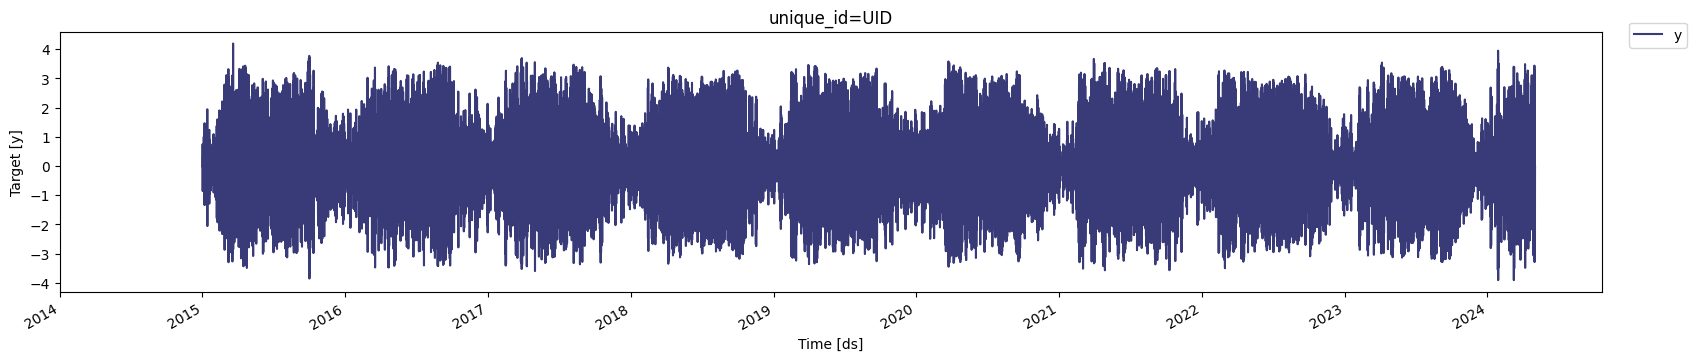

In [ ]:
StatsForecast.plot(ts_nhits, engine='matplotlib')

In [ ]:
horizon = 24*5 # We run into GPU-RAM limitations for larger horizons


# in the tune.choice, one can also specify multiple choices and NeuralForecase
# will optimize. That would take too long for us, though.
nhits_config = {
    "learning_rate": tune.choice([1e-3]),                                     # Initial Learning rate
    "max_steps": tune.choice([50]),                                         # Number of SGD steps
    "input_size": tune.choice([5 * horizon]),                                 # input_size = multiplier * horiz
    "batch_size": tune.choice([7]),                                           # Number of series in windows
    "windows_batch_size": tune.choice([256]),                                 # Number of windows in batch
    "n_pool_kernel_size": tune.choice([[2, 2, 2], [16, 8, 1]]),               # MaxPool's Kernelsize
    "n_freq_downsample": tune.choice([[168, 24, 1], [24, 12, 1], [1, 1, 1]]), # Interpolation expressivity ratios
    "activation": tune.choice(['ReLU']),                                      # Type of non-linear activation
    "n_blocks":  tune.choice([[1, 1, 1]]),                                    # Blocks per each 3 stacks
    "mlp_units":  tune.choice([[[512, 512], [512, 512], [512, 512]]]),        # 2 512-Layers per block for each stack
    "interpolation_mode": tune.choice(['linear']),                            # Type of multi-step interpolation
    "random_seed": tune.randint(1, 10),
    "scaler_type": tune.choice(['robust']),
    "val_check_steps": tune.choice([100])
  }

In [ ]:
models = [AutoNHITS(h=horizon,
                    loss=DistributionLoss(distribution='StudentT', level=[80, 90]),
                    config=nhits_config,
                    num_samples=3)] # num_samples war 5

nf = NeuralForecast(
    models=models,
    freq="1h"
)

In [ ]:
#Y_df = PandasDataset.from_long_dataframe(solar_ts_series_gp, target='y', item_id='unique_id', timestamp='ds', freq='15min')
nf.fit(df=ts_nhits[1:5000])#[1:326921])

/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-07-27 11:07:05,601	INFO worker.py:1781 -- Started a local Ray instance.
2024-07-27 11:07:07,490	INFO tune.py:253 -- Initializing Ray automatically. For cluster usage or custom Ray initialization, call `ray.init(...)` before `Tuner(...)`.


+--------------------------------------------------------------------+
| Configuration for experiment     _train_tune_2024-07-27_11-07-01   |
+--------------------------------------------------------------------+
| Search algorithm                 BasicVariantGenerator             |
| Scheduler                        FIFOScheduler                     |
| Number of trials                 3                                 |
+--------------------------------------------------------------------+

View detailed results here: /root/ray_results/_train_tune_2024-07-27_11-07-01
To visualize your results with TensorBoard, run: `tensorboard --logdir /tmp/ray/session_2024-07-27_11-07-01_363785_84587/artifacts/2024-07-27_11-07-07/_train_tune_2024-07-27_11-07-01/driver_artifacts`


(_train_tune pid=85508) /usr/local/lib/python3.10/dist-packages/ray/tune/integration/pytorch_lightning.py:198: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=85508) Seed set to 2
(_train_tune pid=85508) /usr/local/lib/python3.10/dist-packages/neuralforecast/common/_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
(_train_tune pid=85508)   warnings.warn(
(_train_tune pid=85508) GPU available: False, used: False
(_train_tune pid=85508) TPU available: False, using: 0 TPU cores
(_train_tune pid=85508) HPU available: False, using: 0 HPUs
(_train_tune pid=85508) Missing logger folder: /tmp/ray/session_2024-07-27_11-07-01_363785_84587/artifacts/2024-07-27_11-07-07/_train_tune_2024-07-27_11-07-01/working_dirs/_train_tune_58531_00000_0_activation=ReLU,batch_size=7,input_size=600,interpolation_mode=linear,l

Epoch 49: 100%|██████████| 1/1 [00:00<00:00,  4.28it/s, v_num=0, train_loss_step=1.980, train_loss_epoch=1.820]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=85508) 
Epoch 49: 100%|██████████| 1/1 [00:00<00:00,  3.50it/s, v_num=0, train_loss_step=1.980, train_loss_epoch=1.980, valid_loss=2.470]


(_train_tune pid=85508) `Trainer.fit` stopped: `max_steps=50` reached.
(_train_tune pid=85702) /usr/local/lib/python3.10/dist-packages/ray/tune/integration/pytorch_lightning.py:198: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=85702) Seed set to 8
(_train_tune pid=85702) /usr/local/lib/python3.10/dist-packages/neuralforecast/common/_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
(_train_tune pid=85702)   warnings.warn(
(_train_tune pid=85702) GPU available: False, used: False
(_train_tune pid=85702) TPU available: False, using: 0 TPU cores
(_train_tune pid=85702) HPU available: False, using: 0 HPUs
(_train_tune pid=85702) Missing logger folder: /tmp/ray/session_2024-07-27_11-07-01_363785_84587/artifacts/2024-07-27_11-07-07/_train_tune_2024-07-27_11-07-01/working_dirs/_train_tune_58531_00001_1_

Epoch 49: 100%|██████████| 1/1 [00:00<00:00,  4.94it/s, v_num=0, train_loss_step=2.430, train_loss_epoch=2.410]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 32.75it/s]
(_train_tune pid=85702) 
Epoch 49: 100%|██████████| 1/1 [00:00<00:00,  3.85it/s, v_num=0, train_loss_step=2.430, train_loss_epoch=2.430, valid_loss=2.520]


(_train_tune pid=85702) `Trainer.fit` stopped: `max_steps=50` reached.
(_train_tune pid=85891) /usr/local/lib/python3.10/dist-packages/ray/tune/integration/pytorch_lightning.py:198: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=85891) Seed set to 1
(_train_tune pid=85891) /usr/local/lib/python3.10/dist-packages/neuralforecast/common/_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
(_train_tune pid=85891)   warnings.warn(
(_train_tune pid=85891) GPU available: False, used: False
(_train_tune pid=85891) TPU available: False, using: 0 TPU cores
(_train_tune pid=85891) HPU available: False, using: 0 HPUs
(_train_tune pid=85891) Missing logger folder: /tmp/ray/session_2024-07-27_11-07-01_363785_84587/artifacts/2024-07-27_11-07-07/_train_tune_2024-07-27_11-07-01/working_dirs/_train_tune_58531_00002_2_

Epoch 49:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=2.490, train_loss_epoch=2.490]


2024-07-27 11:08:29,827	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/root/ray_results/_train_tune_2024-07-27_11-07-01' in 0.0092s.
INFO:lightning_fabric.utilities.seed:Seed set to 2
(_train_tune pid=85891) `Trainer.fit` stopped: `max_steps=50` reached.
/usr/local/lib/python3.10/dist-packages/neuralforecast/common/_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(



Epoch 49: 100%|██████████| 1/1 [00:00<00:00,  4.13it/s, v_num=0, train_loss_step=2.200, train_loss_epoch=2.490]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 49: 100%|██████████| 1/1 [00:00<00:00,  3.46it/s, v_num=0, train_loss_step=2.200, train_loss_epoch=2.200, valid_loss=2.790]


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [ ]:
fcst_df = nf.predict()
# in my understanding, the AutoNHITS will have this information already
fcst_df = fcst_df.drop("AutoNHITS-median", axis=1)
#fcst_df.columns = fcst_df.columns.str.replace('-median', '')


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:209: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


In [ ]:
#fcst_df.columns = fcst_df.columns.str.replace('-median', '')
fcst_df = fcst_df.reset_index()
fcst_df.head()

In [ ]:
ts_nhits

,unique_id,ds,y
0,UID,2015-01-01 00:00:00+00:00,-1.355870e-09
1,UID,2015-01-01 01:00:00+00:00,-1.355870e-09
2,UID,2015-01-01 02:00:00+00:00,-1.355870e-09
3,UID,2015-01-01 03:00:00+00:00,-1.355870e-09
4,UID,2015-01-01 04:00:00+00:00,-1.355870e-09
...,...,...,...
81809,UID,2024-05-01 17:00:00+00:00,-2.322542e+00
81810,UID,2024-05-01 18:00:00+00:00,-1.024297e+00
81811,UID,2024-05-01 19:00:00+00:00,-1.324467e-01
81812,UID,2024-05-01 20:00:00+00:00,-1.206162e-04


/usr/local/lib/python3.10/dist-packages/statsforecast/core.py:1447: FutureWarning: Passing the ids as the index is deprecated. Please provide them as a column instead.
  warnings.warn(


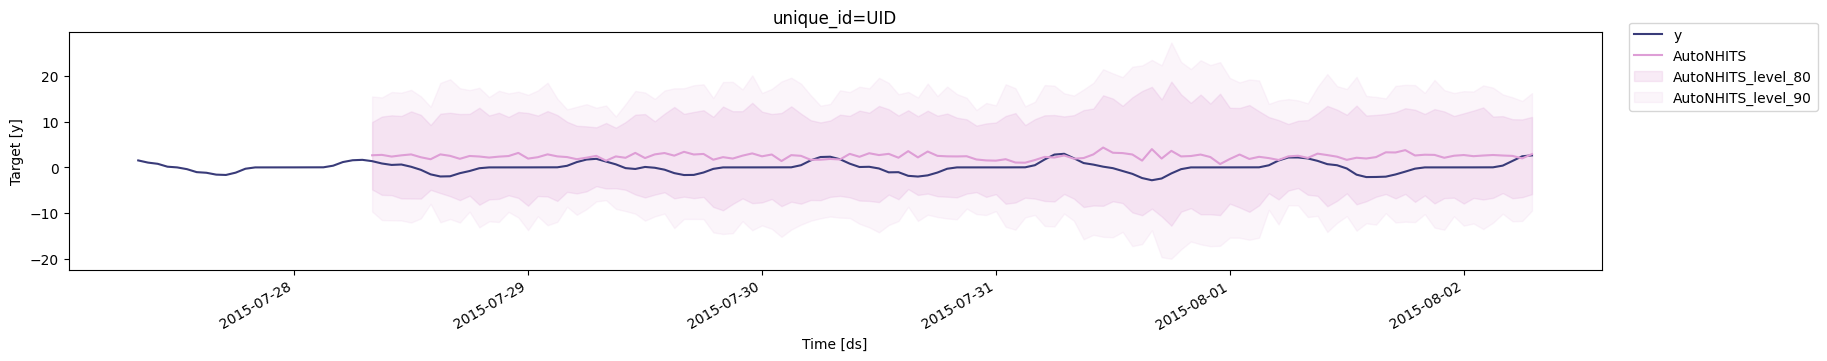

In [ ]:
# -- ansonsten, falls das nicht geht, so setze den plot wie den GARCH-prediction-plot fort. Ne Sache von <20 Minuten :)
# fcst_df.set_index("unique_id").drop("AutoNHITS", axis=1)
StatsForecast.plot(ts_nhits[5000-24:(5000+5*24)], fcst_df,engine='matplotlib', level=[80, 90])#, )

In [ ]:
# ... ooder statt fit+predict
if True:
  val_size = 96*10
  test_size = 96*10
  cv_df = nf.cross_validation(ts_nhits, n_windows=2)
  %%capture
  Y_hat_df = nf.cross_validation(df=ts_nhits, val_size=val_size,
                                test_size=test_size, n_windows=None)

+--------------------------------------------------------------------+
| Configuration for experiment     _train_tune_2024-07-27_11-25-42   |
+--------------------------------------------------------------------+
| Search algorithm                 BasicVariantGenerator             |
| Scheduler                        FIFOScheduler                     |
| Number of trials                 3                                 |
+--------------------------------------------------------------------+

View detailed results here: /root/ray_results/_train_tune_2024-07-27_11-25-42
To visualize your results with TensorBoard, run: `tensorboard --logdir /tmp/ray/session_2024-07-27_11-07-01_363785_84587/artifacts/2024-07-27_11-25-43/_train_tune_2024-07-27_11-25-42/driver_artifacts`
(raylet) Warning: The actor ImplicitFunc is very large (29 MiB). Check that its definition is not implicitly capturing a large array or other object in scope. Tip: use ray.put() to put large objects in the Ray object store.

(_train_tune pid=90227) /usr/local/lib/python3.10/dist-packages/ray/tune/integration/pytorch_lightning.py:198: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=90227) Seed set to 4
(_train_tune pid=90227) /usr/local/lib/python3.10/dist-packages/neuralforecast/common/_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
(_train_tune pid=90227)   warnings.warn(
(_train_tune pid=90227) GPU available: False, used: False
(_train_tune pid=90227) TPU available: False, using: 0 TPU cores
(_train_tune pid=90227) HPU available: False, using: 0 HPUs
(_train_tune pid=90227) Missing logger folder: /tmp/ray/session_2024-07-27_11-07-01_363785_84587/artifacts/2024-07-27_11-25-43/_train_tune_2024-07-27_11-25-42/working_dirs/_train_tune_58531_00000_0_activation=ReLU,batch_size=7,input_size=600,interpolation_mode=linear,l

Epoch 49: 100%|██████████| 1/1 [00:01<00:00,  0.85it/s, v_num=0, train_loss_step=2.810, train_loss_epoch=2.750]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 34.93it/s]
(_train_tune pid=90227) 
Epoch 49: 100%|██████████| 1/1 [00:01<00:00,  0.81it/s, v_num=0, train_loss_step=2.810, train_loss_epoch=2.810, valid_loss=2.700]


(_train_tune pid=90227) `Trainer.fit` stopped: `max_steps=50` reached.
(_train_tune pid=90651) /usr/local/lib/python3.10/dist-packages/ray/tune/integration/pytorch_lightning.py:198: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=90651) Seed set to 1
(_train_tune pid=90651) /usr/local/lib/python3.10/dist-packages/neuralforecast/common/_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
(_train_tune pid=90651)   warnings.warn(
(_train_tune pid=90651) GPU available: False, used: False
(_train_tune pid=90651) TPU available: False, using: 0 TPU cores
(_train_tune pid=90651) HPU available: False, using: 0 HPUs
(_train_tune pid=90651) Missing logger folder: /tmp/ray/session_2024-07-27_11-07-01_363785_84587/artifacts/2024-07-27_11-25-43/_train_tune_2024-07-27_11-25-42/working_dirs/_train_tune_58531_00001_1_

Epoch 49: 100%|██████████| 1/1 [00:01<00:00,  0.79it/s, v_num=0, train_loss_step=1.660, train_loss_epoch=2.010]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=90651) 
Epoch 49: 100%|██████████| 1/1 [00:01<00:00,  0.76it/s, v_num=0, train_loss_step=1.660, train_loss_epoch=1.660, valid_loss=1.660]


(_train_tune pid=90651) `Trainer.fit` stopped: `max_steps=50` reached.
(_train_tune pid=91068) /usr/local/lib/python3.10/dist-packages/ray/tune/integration/pytorch_lightning.py:198: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=91068) Seed set to 1
(_train_tune pid=91068) /usr/local/lib/python3.10/dist-packages/neuralforecast/common/_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
(_train_tune pid=91068)   warnings.warn(
(_train_tune pid=91068) GPU available: False, used: False
(_train_tune pid=91068) TPU available: False, using: 0 TPU cores
(_train_tune pid=91068) HPU available: False, using: 0 HPUs
(_train_tune pid=91068) Missing logger folder: /tmp/ray/session_2024-07-27_11-07-01_363785_84587/artifacts/2024-07-27_11-25-43/_train_tune_2024-07-27_11-25-42/working_dirs/_train_tune_58531_00002_2_

Epoch 49:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=1.890, train_loss_epoch=1.890]


2024-07-27 11:29:58,547	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/root/ray_results/_train_tune_2024-07-27_11-25-42' in 0.0093s.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Epoch 49: 100%|██████████| 1/1 [00:01<00:00,  0.84it/s, v_num=0, train_loss_step=1.620, train_loss_epoch=1.890]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 34.21it/s]

(_train_tune pid=91068) 
Epoch 49: 100%|██████████| 1/1 [00:01<00:00,  0.80it/s, v_num=0, train_loss_step=1.620, train_loss_epoch=1.620, valid_loss=1.450]


/usr/local/lib/python3.10/dist-packages/neuralforecast/common/_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
(_train_tune pid=91068) `Trainer.fit` stopped: `max_steps=50` reached.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:209: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
UsageError: Line magic function `%%capture` not found.


In [ ]:
ts_nhits

,unique_id,ds,y
0,UID,2015-01-01 00:00:00+00:00,-1.355870e-09
1,UID,2015-01-01 01:00:00+00:00,-1.355870e-09
2,UID,2015-01-01 02:00:00+00:00,-1.355870e-09
3,UID,2015-01-01 03:00:00+00:00,-1.355870e-09
4,UID,2015-01-01 04:00:00+00:00,-1.355870e-09
...,...,...,...
81809,UID,2024-05-01 17:00:00+00:00,-2.322542e+00
81810,UID,2024-05-01 18:00:00+00:00,-1.024297e+00
81811,UID,2024-05-01 19:00:00+00:00,-1.324467e-01
81812,UID,2024-05-01 20:00:00+00:00,-1.206162e-04


In [ ]:
Y_hat_df = Y_hat_df.reset_index(drop=True)
Y_hat_df = Y_hat_df[(Y_hat_df['unique_id']=='OT') & (Y_hat_df['cutoff']=='2018-02-11 12:00:00')]
Y_hat_df = Y_hat_df.drop(columns=['y','cutoff'])

In [ ]:
plot_df = Y_df.merge(Y_hat_df, on=['unique_id','ds'], how='outer').tail(96*10+50+96*4).head(96*2+96*4)

plt.plot(plot_df['ds'], plot_df['y'], c='black', label='True')
plt.plot(plot_df['ds'], plot_df['AutoNHITS-median'], c='blue', label='median')
plt.fill_between(x=plot_df['ds'],
                    y1=plot_df['AutoNHITS-lo-90'], y2=plot_df['AutoNHITS-hi-90'],
                    alpha=0.4, label='level 90')
plt.legend()
plt.grid()
plt.plot()

In [ ]:
cv_df.columns = cv_df.columns.str.replace('-median', '')

In [ ]:
cv_df.head()

In [ ]:
for cutoff in cv_df['cutoff'].unique():
    StatsForecast.plot(
        Y_df,
        cv_df.query('cutoff == @cutoff').drop(columns=['y', 'cutoff']),
        max_insample_length=48 * 4,
        unique_ids=['H185'],
        engine='matplotlib'
    )

In [ ]:
# as an aside, NeuralForecast also supports LSTM, so one could also do a full model comparison as follows:

if False:
  config_lstm = {
      "input_size": tune.choice([48, 48*2, 48*3]),              # Length of input window
      "encoder_hidden_size": tune.choice([64, 128]),            # Hidden size of LSTM cells
      "encoder_n_layers": tune.choice([2,4]),                   # Number of layers in LSTM
      "learning_rate": tune.loguniform(1e-4, 1e-2),             # Initial Learning rate
      "scaler_type": tune.choice(['robust']),                   # Scaler type
      "max_steps": tune.choice([500, 1000]),                    # Max number of training iterations
      "batch_size": tune.choice([1, 4]),                        # Number of series in batch
      "random_seed": tune.randint(1, 20),                       # Random seed
  }

  models.append(AutoLSTM(h=48, config=config_lstm, loss=MQLoss(), num_samples=2))
# .. then run NeuralForecast as above.

# Model Class, Backtesting, Metrics (from Andrea, ready)


In [ ]:
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor

In [ ]:
if False:
  # Plot Naive Model
  naive_model = moving_average(ts)

  test_date_start = '2024-01-01 00:00+00:00'
  test_ts = ts[test_date_start:]
  naive_model_print = naive_model[test_date_start:]

  plt.figure(figsize=(12, 6))
  plt.plot(test_ts.index, test_ts, label='Original')
  plt.plot(naive_model_print.index, naive_model_print, label='Moving average', linestyle='--')
  plt.legend()
  plt.title('Naive Model v.s. Original Data')
  plt.xlabel('Date')
  plt.ylabel('Time Series')
  plt.show()

In [ ]:
class TimeSeriesPredictionModel():
    """
    Time series prediction model implementation

    Parameters
    ----------
        model_class : class
            Choice of regressor
        model_params : dict
            Definition of model specific tuning parameters

    Functions
    ----------
        init: Initialize model with given parameters
        train : Train chosen model
        forecast : Apply trained model to prediction period and generate forecast DataFrame
    """
    def __init__(self, model_class, model_params: dict) -> None:
        """Initialize a new instance of time_series_prediction_model."""
        self.model_class = model_class
        self.model_params = model_params
        self.model = None
        self.is_univariate = 'endog' in model_class.__init__.__code__.co_varnames

    def train(self, X_train: pd.DataFrame = None, y_train: pd.Series = None, train_series: pd.Series = None) -> None:
        """Train chosen model."""
        # special case
        print(self.model)
        if isinstance(self.model, FFT):
            self.model.fit(X_train)
        else:
            print("WRONNG path")

        if self.is_univariate:
            if train_series is None:
                raise ValueError("train_series must be provided for univariate models")
            self.train_series = train_series
            self.model = self.model_class(endog=self.train_series, **self.model_params)
            self.model = self.model.fit()
        else:
            if X_train is None or y_train is None:
                raise ValueError("X_train and y_train must be provided for multivariate models")
            self.X_train = X_train
            self.y_train = y_train
            print("hello world")
            self.model = self.model_class(**self.model_params)
            self.model.fit(self.X_train, self.y_train)

    def forecast(self, X_test: pd.DataFrame = None, start_date: str = None, end_date: str = None) -> pd.DataFrame:
        """Apply trained model to prediction period and generate forecast DataFrame."""
        if self.is_univariate:
            #if steps is None:
            if start_date is None or end_date is None:
                raise ValueError("start_date and end_date must be provided for univariate models")
            #forecast = self.model.predict(start = start_date, end= end_date, typ = 'levels')
            # Make predictions
            start_date = pd.to_datetime(start_date)
            end_date = pd.to_datetime(end_date)
            forecast = self.model.predict(start=start_date, end=end_date, typ='levels')

            # forecast = self.model.forecast(steps)
            forecast_df = pd.DataFrame(forecast, columns=['Forecast'])
        else:
            if X_test is None:
                raise ValueError("X_test must be provided for multivariate models")
            self.X_test = X_test
            forecast_df = pd.DataFrame(self.model.predict(self.X_test), index=self.X_test.index)
            forecast_df.index.name = 'Datum'
        return forecast_df

In [ ]:
# Backtesting with sliding window

def backtesting(X_train: pd.DataFrame, y_train: pd.DataFrame,
                X_test: pd.DataFrame, y_test: pd.DataFrame,
                model: TimeSeriesPredictionModel, prediction_step_size: int=96):
    """
    Perform rolling forecast backtesting for a time series prediction model using
    specified train and test datasets, and a given model.

    This function splits the test data into multiple windows based on the
    prediction_step_size and sequentially forecasts each window. After each
    forecasting step, the window of test data used for the current prediction is
    added to the training data, and the earliest window of the training data is
    removed. The predictions are stored in a DataFrame alongside the original test data values.

    Args:
        X_train (pd.DataFrame): Training feature dataset.
        y_train (pd.DataFrame): Training target dataset.
        X_test (pd.DataFrame): Testing feature dataset.
        y_test (pd.DataFrame): Testing target dataset.
        model (TimeSeriesPredictionModel): The model used for time series forecasting.
        prediction_step_size (int): The number of time steps to predict at each iteration.

    Returns:
        pd.DataFrame: A DataFrame with two columns 'Original' and 'Predictions',
                      containing the actual values from y_test and the predictions
                      made by the model, respectively.
    """

    # initializing output df
    predictions = pd.DataFrame(index=y_test.index, columns=['Original', 'Predictions'])
    predictions['Original'] = y_test

    for i in range(0, len(X_test)-prediction_step_size, prediction_step_size):
        end_idx = i + prediction_step_size
        forecast_index= X_test.iloc[i:end_idx].index

        # fit model and predict
        model.train(X_train, y_train)
        forecast = model.forecast(X_test.iloc[i:end_idx])
        predictions.loc[forecast_index, 'Predictions'] = forecast.to_numpy()

        print(f'Finished Forecast for {forecast_index[-1].date()}')

        # delete old time window from train data
        X_train = X_train.drop(X_train.head(prediction_step_size).index)
        y_train = y_train.drop(y_train.head(prediction_step_size).index)

        # add next time window to train data
        X_train = pd.concat([X_train, X_test.iloc[i:end_idx]])
        y_train = pd.concat([y_train, y_test.iloc[i:end_idx]])

    return predictions

In [ ]:
# Metrics

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score#, root_mean_squared_error

def evaluation(y_true, y_pred):

    """
    Calculate various error metrics to evaluate the accuracy of a regression model.

    This function computes the mean absolute error (MAE), mean absolute percentage error (MAPE),
    mean squared error (MSE), coefficient of determination (R^2 score), and root mean squared error (RMSE)
    between the actual and predicted values.

    Args:
        y_true (array-like): True values for the target variable.
        y_pred (array-like): Predicted values generated by the model.

    Returns:
        tuple: A tuple containing:
               - mae (float): Mean absolute error.
               - mape (float): Mean absolute percentage error.
               - mse (float): Mean squared error.
               - r2 (float): R^2 score, measuring the proportion of variation explained by the model.
               - rmse (float): Root mean squared error.

    """

    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    #rmse = root_mean_squared_error(y_true, y_pred)

    return mae, mape, mse, r2#, rmse

# Univariate data processing

In [ ]:
import matplotlib.pyplot as plt
from statsmodels.graphics import tsaplots
from statsmodels.tsa.stattools import acf

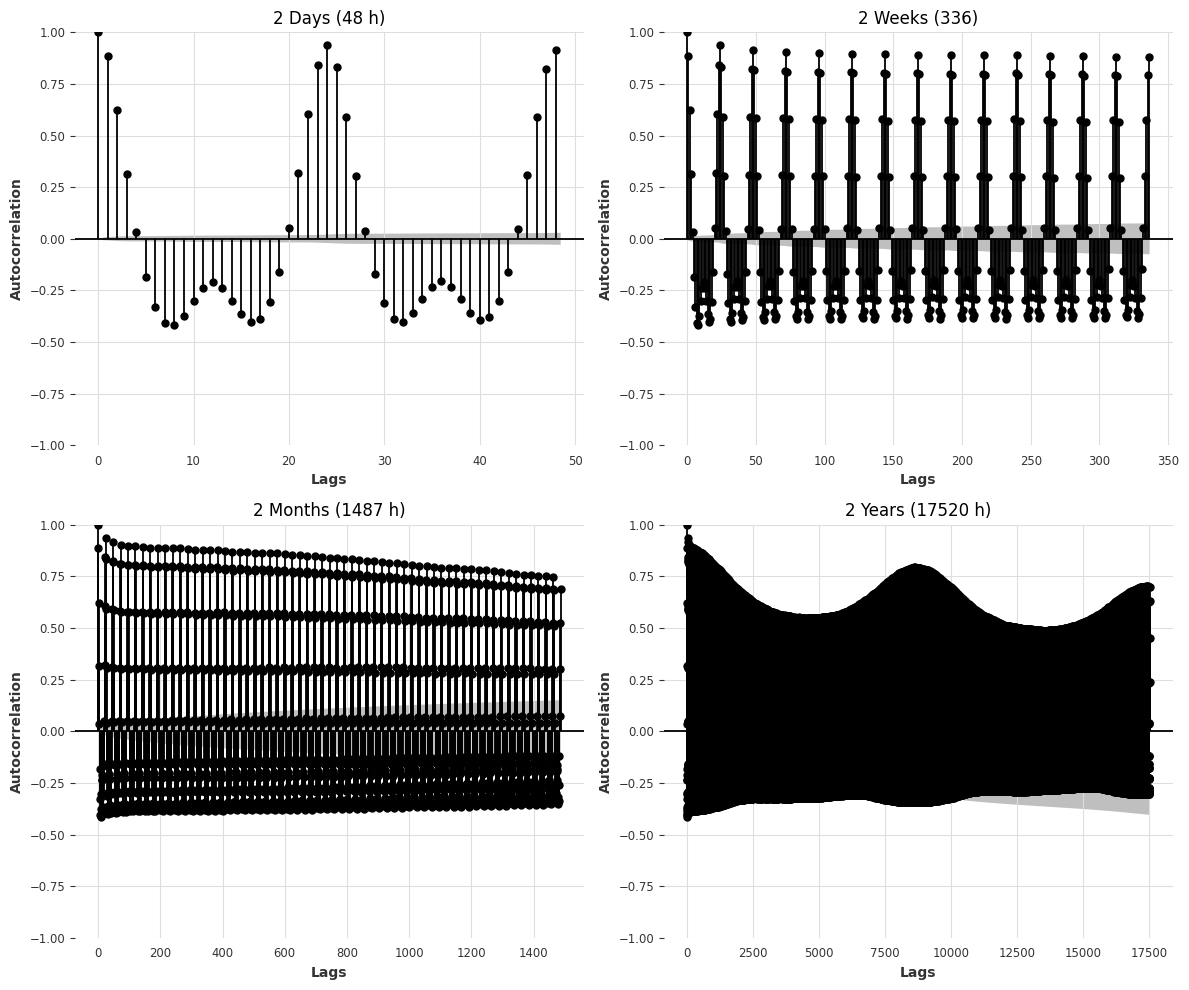

Top 5 lags with highest combined autocorrelation values:
Lag 24: 0.9366
Lag 48: 0.9159
Lag 72: 0.9045
Lag 96: 0.8987
Lag 120: 0.8957


In [ ]:
# Autocorrelation plots
x_label = 'Lags'
y_label = 'Autocorrelation'

# Titles for each subplot
plot_titles = ['2 Days (48 h)', '2 Weeks (336)', '2 Months (1487 h)', '2 Years (17520 h)']
lags = [48, 336, 1487, 17520]

# X and Y labels
x_label = 'Lags'
y_label = 'Autocorrelation'

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
all_autocorr_values = {}

for i, ax in enumerate(axes.flatten()):
    tsaplots.plot_acf(ts, ax=ax, lags=lags[i])
    ax.set_title(plot_titles[i])
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)

    # Compute autocorrelation values
    autocorr_values = acf(ts, nlags=lags[i])

    # Collect all autocorrelation values
    for lag in range(1, len(autocorr_values)):
        if lag not in all_autocorr_values:
            all_autocorr_values[lag] = []
        all_autocorr_values[lag].append(autocorr_values[lag])

plt.tight_layout()
plt.show()

# Combine all autocorrelation values and find the highest values
combined_autocorr_values = {lag: np.mean(values) for lag, values in all_autocorr_values.items()}

# Get the highest values
sorted_lags = sorted(combined_autocorr_values.items(), key=lambda item: item[1], reverse=True)
sorted_lags_filtered = [item for item in sorted_lags if item[0] >= 24]
top_5_combined_lags = sorted_lags_filtered[:5]
least_3_combined_lags = sorted_lags_filtered[-3:]

print("Top 5 lags with highest combined autocorrelation values:")
for lag, value in top_5_combined_lags:
    print(f"Lag {lag}: {value:.4f}")

In [ ]:
# Data preparation for univariate TimeSeriesPredictionModel
lags = [24, 48, 72, 96, 120]

data = pd.DataFrame(index=ts.index)
data['Original'] = ts
for lag in lags:
    data[f'{lag}_Lag'] = ts.shift(lag)

In [ ]:
# Data train-test split
train_df = data[:'2022-12-31 23:00:00+00:00']
y_train = train_df[['Original']]
X_train = train_df.drop(columns=['Original'])

valuation_df = data['2023-01-01 00:00:00+00:00':'2023-12-31 23:00:00+00:00']
y_valuation = valuation_df[['Original']]
X_valuation = valuation_df.drop(columns=['Original'])

test_df = data['2024-01-01 00:00:00+00:00':]
y_test = test_df[['Original']]
X_test = test_df.drop(columns=['Original'])

In [ ]:
print(data.index.unique())

# Univariate Models

## Naive model: Moving Average

In [ ]:
# Moving average model
def moving_average(data: pd.DataFrame, window_size: int=3, shift_size: int=24):
    moving_avg = data.rolling(window=window_size).mean()
    shifted_moving_avg = moving_avg.shift(shift_size)
    return(shifted_moving_avg)

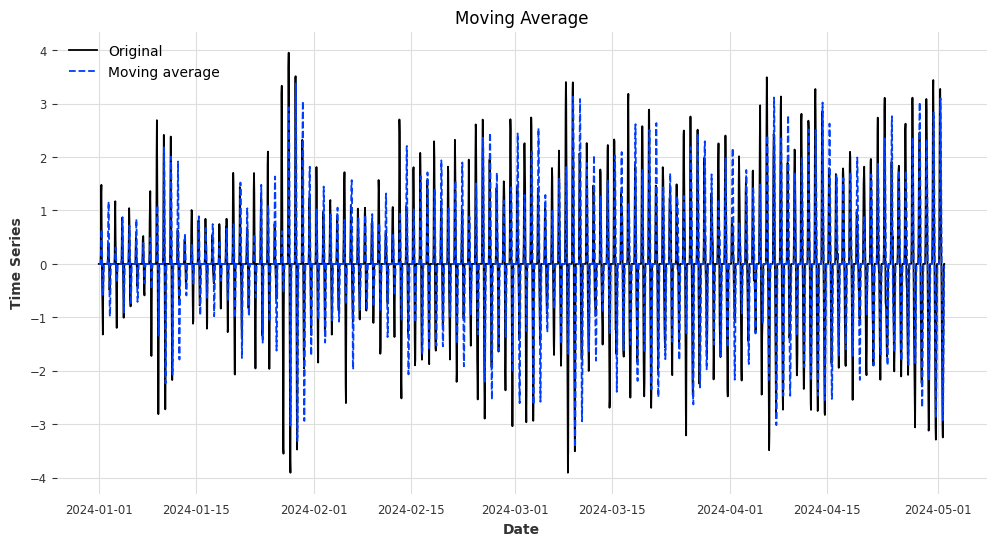

In [ ]:
# Plot Naive Model Predictions
naive_model = moving_average(ts)

test_date_start = '2024-01-01 00:00:00+00:00'
test_ts = ts[test_date_start:]
naive_model_print = naive_model[test_date_start:]

plt.figure(figsize=(12, 6))
plt.plot(test_ts.index, test_ts, label='Original')
plt.plot(naive_model_print.index, naive_model_print, label='Moving average', linestyle='--')
plt.legend()
plt.title('Moving Average')
plt.xlabel('Date')
plt.ylabel('Time Series')
plt.show()

In [ ]:
# Detail Plot Naive Model Predictions
naive_model = moving_average(ts)

test_date_start = '2024-04-24 00:00+00:00'
test_ts = ts[test_date_start:]
naive_model_print = naive_model[test_date_start:]

plt.figure(figsize=(12, 6))
plt.plot(test_ts.index, test_ts, label='Original')
plt.plot(naive_model_print.index, naive_model_print, label='Moving average', linestyle='--')
plt.legend()
plt.title('Moving Average')
plt.xlabel('Date')
plt.ylabel('Time Series')
plt.show()

In [ ]:
# Metrics Naive Model
mae, mape, mse, r2, rmse = evaluation(test_ts, naive_model_print)

print(f'Model: Naive Moving Average \n Mean absolute error: {mae}\n Mean absolute percentage error: {mape} \n Mean squared error: {mse} \n r2_score: {r2} \n Root mean squared error: {rmse}')

## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
# Initializing random forest regressor as instance of TimeSeriesPredictionModel
rdnf = TimeSeriesPredictionModel(RandomForestRegressor, {'n_estimators': 150, 'criterion': 'squared_error', 'max_depth': 10})

In [ ]:
rdnf_pred = backtesting(X_train, y_train, X_test, y_test, rdnf)
rdnf_pred = rdnf_pred.dropna()

In [ ]:
# Plot Random Forest Predictions
test_date_start = '2024-01-01 00:00+00:00'
test_ts = ts[test_date_start:]

plt.figure(figsize=(12, 6))
plt.plot(test_ts.index, test_ts, label='Original')
plt.plot(rdnf_pred.index, rdnf_pred['Predictions'], label='Random Forest', linestyle='--')
plt.legend()
plt.title('Random Forest')
plt.xlabel('Date')
plt.ylabel('Time Series')
plt.show()

In [ ]:
# Detail Plot Random Forest Predictions
test_date_start = '2024-04-24 00:00+00:00'
test_date_end = '2024-04-30 23:00:00+00:00'

plt.figure(figsize=(12, 6))
plt.plot(test_ts[test_date_start:test_date_end].index, test_ts[test_date_start:test_date_end], label='Original')
plt.plot(rdnf_pred[test_date_start:test_date_end].index, rdnf_pred[test_date_start:test_date_end]['Predictions'], label='Random Forest', linestyle='--')
plt.legend()
plt.title('Random Forest')
plt.xlabel('Date')
plt.ylabel('Time Series')
plt.show()

In [ ]:
mae, mape, mse, r2, rmse = evaluation(rdnf_pred['Original'], rdnf_pred['Predictions'])

print(f'Model: Random Forest \n Mean absolute error: {mae}\n Mean absolute percentage error: {mape} \n Mean squared error: {mse} \n r2_score: {r2} \n Root mean squared error: {rmse}')

In [ ]:
# Metrics comparison random forest default settings v.s. optimized hyperparameters
rdn_forest_default = [0.85, 2.54, 0.83, 1.59]
rdn_forest_optimized = [mae, mse, r2, rmse]
index = ['mae', 'mse',
         'r2', 'rmse']
df = pd.DataFrame({'Rdn Forest': rdn_forest_default,
                   'Rdn Forest optimized': rdn_forest_optimized}, index=index)
ax = df.plot.bar(rot=0)

In [ ]:
# CatBoost

In [ ]:
from catboost import CatBoostRegressor

# Initializing CatBoost regressor as instance of TimeSeriesPredictionModel
cboost = TimeSeriesPredictionModel(CatBoostRegressor, {'iterations': 20, 'learning_rate': 0.25, 'depth': 16})

In [ ]:

cboost_pred = backtesting(X_train, y_train, X_test, y_test, cboost)
cboost_pred = cboost_pred.dropna()

In [ ]:
test_date_start = '2024-01-01 00:00+00:00'
test_ts = ts[test_date_start:]

plt.figure(figsize=(12, 6))
plt.plot(test_ts.index, test_ts, label='Original')
plt.plot(cboost_pred.index, rdnf_pred['Predictions'], label='CatBoost', linestyle='--')
plt.legend()
plt.title('CatBoost')
plt.xlabel('Date')
plt.ylabel('Time Series')
plt.show()

In [ ]:
test_date_start = '2024-04-27 00:00+00:00'
test_date_end = '2024-05-03 23:00:00+00:00'

plt.figure(figsize=(12, 6))
plt.plot(test_ts[test_date_start:test_date_end].index, test_ts[test_date_start:test_date_end], label='Original')
plt.plot(cboost_pred[test_date_start:test_date_end].index, cboost_pred[test_date_start:test_date_end]['Predictions'], label='CatBoost', linestyle='--')
plt.legend()
plt.title('CatBoost')
plt.xlabel('Date')
plt.ylabel('Time Series')
plt.show()

In [ ]:
mae, mape, mse, r2, rmse = evaluation(cboost_pred['Original'], cboost_pred['Predictions'])

print(f'Model: CatBoost \n Mean absolute error: {mae}\n Mean absolute percentage error: {mape} \n Mean squared error: {mse} \n r2_score: {r2} \n Root mean squared error: {rmse}')

## FFT model with backtesting (currently defunct)

In [ ]:
model = FFT(nr_freqs_to_keep=None)


In [ ]:
# Initializing CatBoost regressor as instance of TimeSeriesPredictionModel
fft_model = TimeSeriesPredictionModel(FFT, {"required_matches":{"day", "month"}, "nr_freqs_to_keep":None})

In [ ]:
ts_train_orig = solar_ts_series[:train_size]
ts_test_orig = solar_ts_series[train_size:]

darts_ts_train_orig = TimeSeries.from_series(ts_train_orig)
darts_ts_test_orig = TimeSeries.from_series(ts_test_orig)

In [ ]:
isinstance(fft_model.model, FFT)

True

In [ ]:
fft_model_pred = backtesting(X_train, y_test, X_test, y_test, fft_model)
fft_model_pred = fft_model_pred.dropna()

FFT(nr_freqs_to_keep=None, required_matches={'day', 'month'})
                                 24_Lag        48_Lag        72_Lag  \
2015-01-01 00:00:00+00:00           NaN           NaN           NaN   
2015-01-01 01:00:00+00:00           NaN           NaN           NaN   
2015-01-01 02:00:00+00:00           NaN           NaN           NaN   
2015-01-01 03:00:00+00:00           NaN           NaN           NaN   
2015-01-01 04:00:00+00:00           NaN           NaN           NaN   
...                                 ...           ...           ...   
2022-12-31 19:00:00+00:00  1.506522e-09  1.506522e-09  1.506522e-09   
2022-12-31 20:00:00+00:00  1.506522e-09  1.506522e-09  1.506522e-09   
2022-12-31 21:00:00+00:00  1.506522e-09  1.506522e-09  1.506522e-09   
2022-12-31 22:00:00+00:00  1.506522e-09  1.506522e-09  1.506522e-09   
2022-12-31 23:00:00+00:00  1.506522e-09  1.506522e-09  1.506522e-09   

                                 96_Lag       120_Lag  
2015-01-01 00:00:00+00:00    

NameError: name 'kwitt' is not defined

# Optimizer univariate models

In [ ]:
import random
from sklearn.model_selection import train_test_split

def random_search_optimization(model_class, param_grid, train_series=None, X_train=None, y_train=None,
                               X_val=None, y_val=None, n_iter=10, scoring_function=None):
    """
    Perform random search optimization on model parameters.

    Parameters
    ----------
    model_class : class
        Choice of model class (e.g., ARIMA, LinearRegression)
    param_grid : dict
        Dictionary with parameter names as keys and lists of parameter settings to try as values
    train_series : pd.Series, optional
        Training data for univariate models
    X_train : pd.DataFrame, optional
        Training features for multivariate models
    y_train : pd.Series, optional
        Training target for multivariate models
    X_val : pd.DataFrame, optional
        Validation features for multivariate models
    y_val : pd.Series, optional
        Validation target for multivariate models
    n_iter : int
        Number of parameter settings that are sampled
    scoring_function : function
        Function to evaluate model performance, should return a single score

    Returns
    -------
    best_params : dict
        Best parameter combination found
    best_score : float
        Best score obtained
    """

    def sample_params(param_grid):
        return {key: random.choice(values) for key, values in param_grid.items()}

    best_score = float('-inf')
    best_params = None

    for i in range(n_iter):
        print(i)
        params = sample_params(param_grid)
        model = TimeSeriesPredictionModel(model_class, params)

        if train_series is not None:
            model.train(train_series=train_series)
            forecast = model.forecast(steps=len(train_series))
            score = scoring_function(train_series[-len(forecast):], forecast)
        else:
            model.train(X_train=X_train, y_train=y_train)
            forecast = model.forecast(X_test=X_val)
            score = scoring_function(y_val, forecast)

        if score > best_score:
            best_score = score
            best_params = params

    return best_params, best_score

In [ ]:
# Model Optimization - Example usage
from sklearn.metrics import mean_squared_error

# Define parameter grid
param_grid = {
    'n_estimators': [50, 100, 150],
    'criterion': ['squared_error'],
    'max_depth': [5, 10, 20]}
    # 'iterations': [20, 25, 30],
    # 'learning_rate': [0.25, 0.5, 0.75],
    # 'depth': [5, 10, 16]}

# Example scoring function
def my_scoring_function(true, pred):
    return -mean_squared_error(true, pred)

# Perform random search optimization
best_params, best_score = random_search_optimization(
    RandomForestRegressor,
    param_grid,
    X_train= X_train,
    y_train= y_train,
    X_val = X_valuation,
    y_val= y_valuation,
    n_iter=10,
    scoring_function=my_scoring_function
)

print("Best Parameters:", best_params)
print("Best Score:", best_score)

# appendix: Extreme Values

In [ ]:
!pip install pyextremes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.4/47.4 kB 1.9 MB/s eta 0:00:00


In [ ]:
from pyextremes import __version__, get_extremes
from pyextremes.plotting import plot_extremes
from pyextremes import EVA
print("pyextremes", __version__)

pyextremes 2.3.2


In [ ]:
# "In order for the analysis results to be meaningful, data needs to be pre-processed by the user.
# This may include removal of data gaps, detrending, interpolation, removal of outliers, etc."
# ==> !! Data needs to be detrended! TODO: Does this also imply constant variance?
# I assume yes and take solar_ts_series_corrected_variance as in input
# TODO: So what exactly does pyextremes expect from the time series?
from pyextremes import EVA

model = EVA(ts)
model

                           Univariate Extreme Value Analysis                            
                                      Source Data                                       
----------------------------------------------------------------------------------------
Data label:                          None      Size:                              81,814
Start:                       January 2015      End:                             May 2024
                                     Extreme Values                                     
----------------------------------------------------------------------------------------
Extreme values have not been extracted
                                         Model                                          
----------------------------------------------------------------------------------------
Model has not been fit to the extremes

In [ ]:
model.get_extremes(method="BM", block_size="365.2425D")

In [ ]:
model.fit_model()

In [ ]:
model

                           Univariate Extreme Value Analysis                            
                                      Source Data                                       
----------------------------------------------------------------------------------------
Data label:                          None      Size:                              81,814
Start:                       January 2015      End:                             May 2024
                                     Extreme Values                                     
----------------------------------------------------------------------------------------
Count:                                 10      Extraction method:                     BM
Type:                                high      Block size:             365 days 05:49:12
                                         Model                                          
----------------------------------------------------------------------------------------
Model:               

In [ ]:
summary = model.get_summary(
    return_period=[1, 2, 5, 10, 25, 50, 100, 250, 500, 1000],
    alpha=0.95,
    n_samples=1000,
)
print(summary)

               return value  lower ci  upper ci
return period                                  
1.0                    -inf       NaN       NaN
2.0                3.582936  3.450986  3.757336
5.0                3.808111  3.594147  4.056691
10.0               3.957197  3.679104  4.264009
25.0               4.145567  3.765808  4.535259
50.0               4.285311  3.835833  4.739937
100.0              4.424023  3.909373  4.951163
250.0              4.606660  3.998227  5.228508
500.0              4.744565  4.063788  5.425198
1000.0             4.882370  4.123532  5.634667


(<Figure size 768x768 with 4 Axes>,
 (<Axes: title={'center': 'Return value plot'}, xlabel='Return period', ylabel='extreme values'>,
  <Axes: title={'center': 'Probability density plot'}, ylabel='Probability density'>,
  <Axes: title={'center': 'Q-Q plot'}, xlabel='Theoretical', ylabel='Observed'>,
  <Axes: title={'center': 'P-P plot'}, xlabel='Theoretical', ylabel='Observed'>))

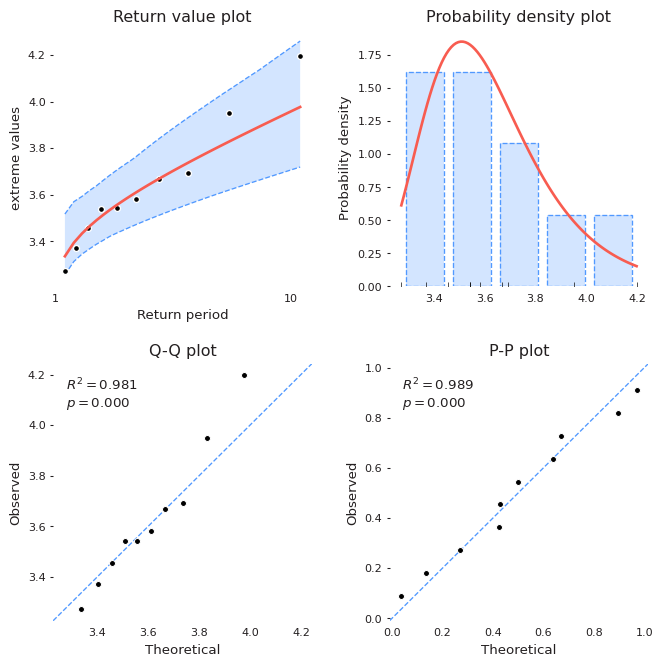

In [ ]:
model.plot_diagnostic(alpha=0.95)

The lib can be used to obtain extreme values - either as the extreme values of a period or as all values larger than a threshold - easily.

Datum
2015-03-20 10:15:00+00:00    9.215622
2016-09-25 07:15:00+00:00    3.757088
2017-03-28 07:15:00+00:00    3.930889
2018-04-07 07:00:00+00:00    3.489774
2019-06-27 06:45:00+00:00    4.476474
2020-03-23 07:00:00+00:00    3.775172
2021-03-30 07:00:00+00:00    3.710929
2022-03-11 07:45:00+00:00    3.423891
2023-04-04 07:00:00+00:00    3.715747
2024-01-28 08:30:00+00:00    4.191150
Name: extreme values, dtype: float64

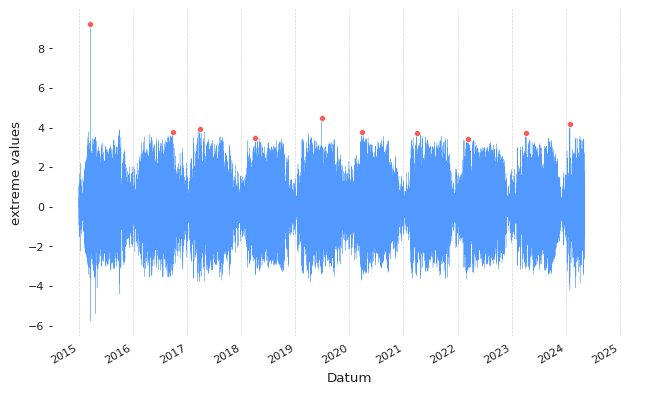

In [ ]:
extremes = get_extremes(
    ts=solar_ts_series_corrected_variance,
    method="BM",
    extremes_type="high",
    block_size="365.2425D",
    errors="raise",
    min_last_block=None,
)

plot_extremes(
    ts=solar_ts_series_corrected_variance,
    extremes=extremes,
    extremes_method="BM",
    extremes_type="low",
    block_size="365.2425D",
)
extremes

In [ ]:
model.get_extremes("POT", threshold=3, r="12H")


(<Figure size 768x480 with 1 Axes>,
 <Axes: xlabel='date-time', ylabel='extreme values'>)

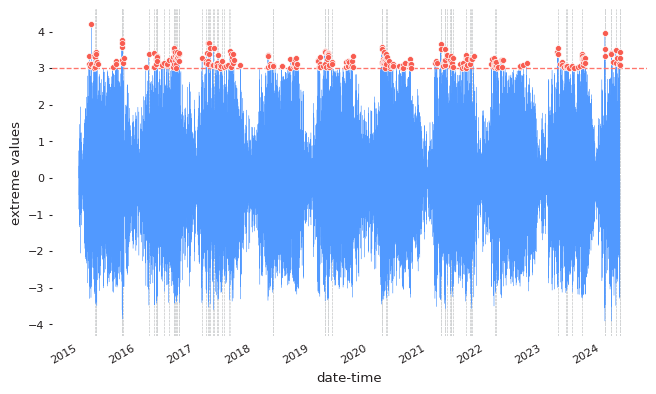

In [ ]:
model.plot_extremes(show_clusters=True)

# discuss: AutoARIMA?

In [ ]:
# auto arima aic criterion
from pmdarima.arima import auto_arima

# get best ar ma
model = auto_arima(solar_ts_series[1:10000],
                   start_p=0, start_q=0,
                   max_p=3, max_q=3, m=1,
                   start_P=0, seasonal=True,
                   d=1, D=1, trace=True,
                   error_action='ignore',
                   suppress_warnings=True,
                   stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-56974.315, Time=5.68 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-57354.029, Time=1.37 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-57224.043, Time=8.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-56976.315, Time=0.78 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-57952.229, Time=8.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-57973.827, Time=4.78 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-57972.816, Time=16.42 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-57977.987, Time=13.13 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-57669.890, Time=14.43 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-57983.957, Time=6.07 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-57913.014, Time=6.30 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-57978.166, Time=24.14 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-57991.967, Time=18.17 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-57896.519, Time=9.09 sec


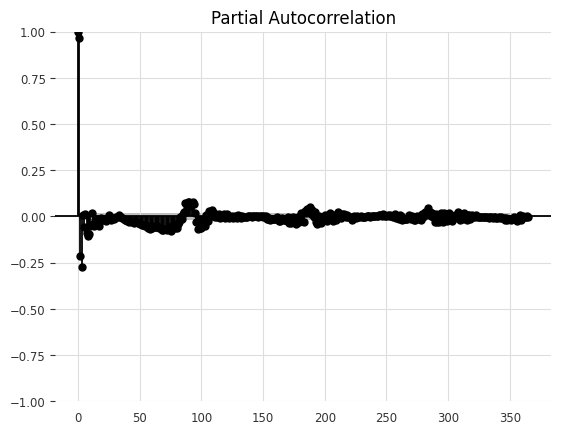

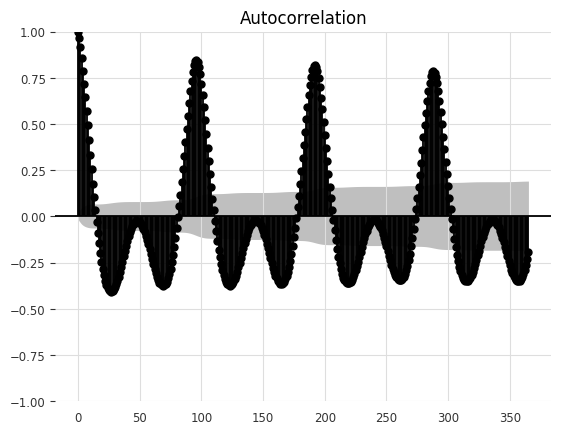

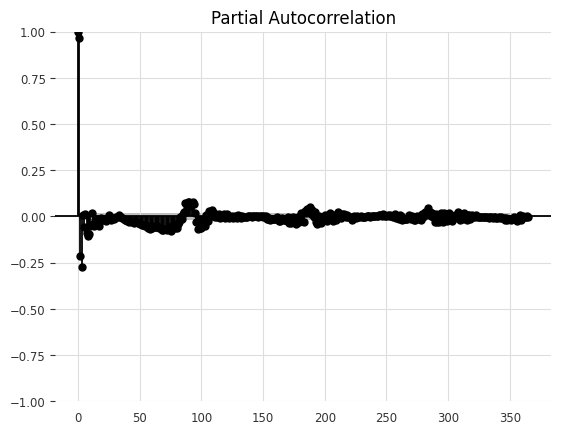

In [ ]:
# acf pacf plot with significNCE LINE
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(solar_ts_series[1:10000], lags=365, alpha=0.05)
plot_pacf(solar_ts_series[1:10000], lags=365, alpha=0.05)


In [ ]:
pred = model.predict(nsteps=4*24*4)
mean_pred, var_pred = pred


# Plot the actual data and the forecast for the last 100 observations
plt.figure(figsize=(10, 6))

# Plot the actual data for the last 100 observations
plt.plot(solar_ts_series_corrected_variance[19900:(20000+4*24*4)], label='Actual Data')

# Plot the forecasted mean, starting from the last actual value
last_observation_index = solar_ts_series_corrected_variance.index[20000]# solar_ts_series_corrected_variance.index[-1]
forecast_index = pd.date_range(start=last_observation_index, periods=len(mean_pred) + 1, freq="15min")[1:]
plt.plot(forecast_index[-100:], mean_pred[-100:], label='Forecasted Mean', color='red')
plt.plot(forecast_index, mean_pred, label='Forecasted Mean', color='red')


# Fill between upper and lower bounds of the forecasted variance
plt.fill_between(forecast_index,
                 mean_pred - np.sqrt(var_pred),
                 mean_pred + np.sqrt(var_pred),
                 color='red', alpha=0.2, label='Forecasted Variance')

plt.title('ARMA-GARCH Forecast (Last 100 Observations)')
plt.xlabel('Time')
plt.ylabel('Returns')
plt.legend()
plt.show()